In [2]:
import sys
import os

import pandas as pd
import numpy as np
import numdifftools as ndt
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.optimize import linear_sum_assignment
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose
from copy import deepcopy
from itertools import product
import importlib
import time
import pickle
import random

import helper_funcs
import HHMM
import optimizor
import stoch_optimizor

from helper_funcs import eta_2_log_Gamma
from helper_funcs import eta0_2_log_delta
from helper_funcs import log_Gamma_2_eta
from helper_funcs import log_delta_2_eta0

np.random.seed(0)
random.seed(0)

In [3]:
date = "Oct-25-2022" #"Sep-25-2022" #"Aug-21-2022" #Oct-19-2022"
param_folder = "/Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/" + date
#param_folder = "/Volumes/One Touch/sublinear-HMM-inference/sim_study/" + date
plot_folder = "/Users/evsi8432/Documents/Research/sublinear-HMM-inference/plt/sim_study/" + date

if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)

methods = ["control","BFGS","GD","CG","SAGA","SVRG"]

tol = 1e-2

In [4]:
def load_optims(T,K,d,data_set):
    
    optims = {}
    times_to_converge = {}
    epochs_to_converge = {}
    lls = {}
    
    for method in methods:
        for partial_E in partial_Es:
            if method in ["BFGS","CG","GD","control"] and partial_E > 0.0:
                pass
            else:

                # get best ll
                best_ll = -np.infty
                best_fname = param_folder + "/T-%d_K-%d-%d_d-%d_%s_%.1f_%03d_%03d" % (T,K[0],K[1],d,method,partial_E,0,data_set)

                # initialize lls
                lls[(method,partial_E)] = []

                # initialize epochs
                epochs_to_converge[(method,partial_E)] = []

                # initialize times
                times_to_converge[(method,partial_E)] = []

                for rand_seed in range(5):

                    fname = param_folder + "/T-%d_K-%d-%d_d-%d_%s_%.1f_%03d_%03d" % (T,K[0],K[1],d,method,partial_E,rand_seed,data_set)

                    try:
                        with open(fname, 'rb') as f:
                            optim = pickle.load(f)
                        #print("loaded file %s" % fname)
                    except:
                        print("file %s does not exist" % fname)
                        continue

                    # check for some issue (likely nan in theta)
                    if len(optim.time_trace) == 0:
                        print("file %s didn't optimize." % fname)
                        continue


                    # get convergence ind
                    converge_ind = min(np.where(np.array(optim.grad_norm_trace) < tol)[0],
                                       default=len(optim.grad_norm_trace)-1)

                    epochs_to_converge[(method,partial_E)].append(optim.epoch_trace[converge_ind])
                    times_to_converge[(method,partial_E)].append(optim.time_trace[converge_ind])
                    lls[(method,partial_E)].append(optim.log_like_trace[converge_ind])

                    if optim.log_like_trace[-1] > best_ll:    
                        optims[(method,partial_E)] = optim
                        best_fname = fname
                        best_ll = optim.log_like_trace[-1]

                #print(best_fname)
                
    return optims,lls,epochs_to_converge,times_to_converge

# Plot boxplots

100000 [3, 1] 3
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_control_0.0_000_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_SAGA_0.5_002_000 does not exist
('control', 0)
('BFGS', 0)
-1.2656382874151177
control model has lower likelihood than a test model
('GD', 0)
-1.3532644295835576
('CG', 0)
-1.2656460567111472
('SAGA', 0)
-1.265638368402554
('SAGA', 0.5)
-1.2656383805294995
('SAGA', 1)
-1.265638357064062
('SVRG', 0)
-1.2656383750763356
('SVRG', 0.5)
-1.2656384146010038
('SVRG', 1)
-1.2656384069423914
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_SAGA_0.5_001_001 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_SAGA_0.5_002_001 does not exist
('control', 0)
('BFGS', 0)
-1.2640298760567557
('GD

file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_SAGA_0.5_000_004 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_SVRG_0.0_000_004 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_SVRG_1.0_000_004 does not exist
('control', 0)
('BFGS', 0)
-2.522714397432326
('GD', 0)
-2.5986992419865502
('CG', 0)
-2.522865898870182
('SAGA', 0)
-2.522704770730336
('SAGA', 0.5)
-2.5227049096044794
('SAGA', 1)
-2.522704765643277
control model has lower likelihood than a test model
('SVRG', 0)
-2.5227047630083295
control model has lower likelihood than a test model
('SVRG', 0.5)
-2.522704820106432
('SVRG', 1)
-2.5227047958693825
100000 [3, 1] 6
[[27.0, 24.0, 29.0, 24.0, 24.0, 25.0, 31.0, 50.0, 31.0, 31.0, 40.0, 28.0, 26.0, 15.0, 28.0, 33.0, 34.0, 37.0, 24.0, 25.0, 34.0], [25.0, 29.0, 25.0, 

('control', 0)
('BFGS', 0)
-2.9696066773047667
('GD', 0)
-3.721555381336919
('CG', 0)
-3.243086195216037
('SAGA', 0)
-2.96325601205222
('SAGA', 0.5)
-3.7521227809911144
('SAGA', 1)
-3.1020507079967605
('SVRG', 0)
-2.9663036812039256
('SVRG', 0.5)
-2.516996036488302
control model has lower likelihood than a test model
('SVRG', 1)
-2.51699462874909
control model has lower likelihood than a test model
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_000_002 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_001_002 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_002_002 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_003_002 does not exist
file /Users/evsi8432/D

/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_3948/944729550.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


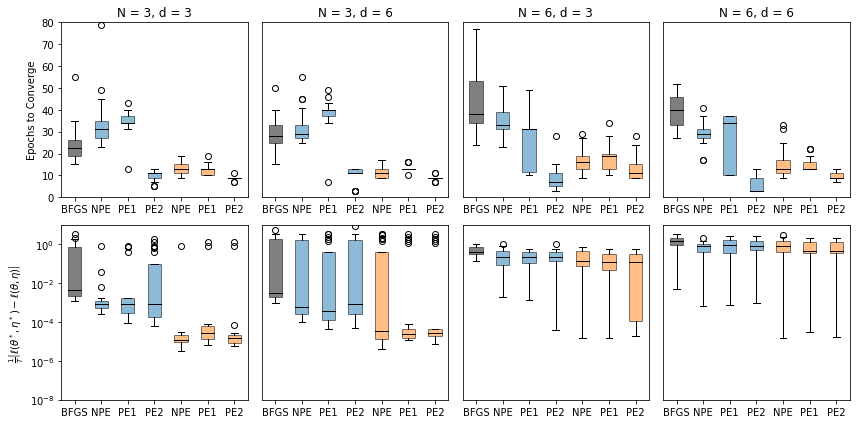

In [5]:
fig1, axs1 = plt.subplots(2,4,figsize = (12,6))
#fig2, axs2 = plt.subplots(2,4,figsize = (10,6))

cmap = cm.get_cmap('tab10')
partial_Es = [0,0.5,1]

for T,K,d in product([100000],[[3,1],[6,1]],[3,6]):
    
    print(T,K,d)
    
    yind = 0 #int(T == 100000)
    xind = int(d == 6) + 2*int(K[0] == 6)

    ll_star = []
    theta_star = []
    eta_star = []
    eta0_star = []
    
    epochs_to_converge = []
    times_to_converge = []
    lls = []
    
    for dataset in range(5):
        
        optims,lls0,epochs_to_converge0,times_to_converge0 = load_optims(T,K,d,dataset)
        
        ll_star.append(optims[("SAGA",0.0)].log_like_trace[-1])
        theta_star.append(optims[("SAGA",0.0)].theta)
        eta_star.append(optims[("SAGA",0.0)].eta)
        eta0_star.append(optims[("SAGA",0.0)].eta0)
        
        lls.append(lls0)
        epochs_to_converge.append(epochs_to_converge0)
        times_to_converge.append(times_to_converge0)
        
        for key in optims:

            print(key)
            if key[0] == 'control':
                continue
            print(optims[key].log_like_trace[-1])

            if ll_star[dataset] < optims[key].log_like_trace[-1]:

                print("control model has lower likelihood than a test model")

                update_ll = True
                for feature,k0,k1 in product(optims[key].features,range(optims[key].K[0]),range(optims[key].K[1])):
                    if optims[key].theta[k0][feature]['log_sig'][k1] < -5:
                        print("...but the test model has ~0 varaince. continuing...")
                        #update_ll = False
                        #break

                if update_ll:
                    ll_star[dataset] = optims[key].log_like_trace[-1]
                    theta_star[dataset] = optims[key].theta
                    eta_star[dataset] = optims[key].eta
                    eta0_star[dataset] = optims[key].eta0

    
    keys = [("BFGS",0.0),("SAGA",0.0),("SAGA",0.5),("SAGA",1.0),("SVRG",0.0),("SVRG",0.5),("SVRG",1.0)]
    labs = ["BFGS","NPE","PE1","PE2","NPE","PE1","PE2"]
    
    data_to_plot = []
    for key in keys:
        key_data = []
        for dataset in range(5):
            key_data.extend(epochs_to_converge[dataset][key])
        data_to_plot.append(key_data)
    
    print(T,K,d)
    print(data_to_plot)

    box = axs1[yind,xind].boxplot(data_to_plot, 
                                  whiskerprops=dict(color="black"),
                                  medianprops=dict(color="black"),
                                  patch_artist=True,
                                  labels=labs)#['BFGS',0,0.5,1])

    linestyles = {("BFGS",0.0):("black","-"),
                  ("CG",0.0)  :("black","--"),
                  ("GD",0.0)  :("black",":"),
                  ("SAGA",0.0):(cmap(0),"-"),
                  ("SAGA",0.5):(cmap(0),"--"),
                  ("SAGA",1.0):(cmap(0),":"),
                  ("SVRG",0.0):(cmap(1),"-"),
                  ("SVRG",0.5):(cmap(1),"--"),
                  ("SVRG",1.0):(cmap(1),":")}

    for patch, key in zip(box['boxes'], keys):
        print(key)
        patch.set_facecolor(linestyles[key][0])
        patch.set_alpha(0.5)

    if xind == 0:
        axs1[yind,xind].set_ylabel("Epochs to Converge")
    else:
        axs1[yind,xind].set_yticks([])
        
    if T == 1000:
        axs1[yind,xind].set_ylim([0,500])
    else:
        axs1[yind,xind].set_ylim([0,80])
        
    axs1[yind,xind].set_title("N = %d, d = %d" % (K[0],d))

    #######
    
    yind = 1

    data_to_plot = []
    for key in keys:
        key_data = []
        for dataset in range(5):
            key_data.extend(ll_star[dataset] - lls[dataset][key])
        data_to_plot.append(key_data)
        
    box = axs1[yind,xind].boxplot(data_to_plot, 
                                  whiskerprops=dict(color="black"),
                                  medianprops=dict(color="black"),
                                  patch_artist=True,
                                  labels=labs)#['BFGS',0,0.5,1])

    linestyles = {("BFGS",0.0):("black","-"),
                  ("CG",0.0)  :("black","--"),
                  ("GD",0.0)  :("black",":"),
                  ("SAGA",0.0):(cmap(0),"-"),
                  ("SAGA",0.5):(cmap(0),"--"),
                  ("SAGA",1.0):(cmap(0),":"),
                  ("SVRG",0.0):(cmap(1),"-"),
                  ("SVRG",0.5):(cmap(1),"--"),
                  ("SVRG",1.0):(cmap(1),":")}

    for patch, key in zip(box['boxes'], keys):
        patch.set_facecolor(linestyles[key][0])
        patch.set_alpha(0.5)

    axs1[yind,xind].set_yscale("log")
    axs1[yind,xind].set_ylim([1e-8,1e1])
        
    if xind == 0:
        axs1[yind,xind].set_ylabel(r"$\frac{1}{T} \left[\ell(\theta^*, \eta^*) - \ell(\theta, \eta)\right]$")
    else:
        axs1[yind,xind].set_yticks([])
        
    #axs1[yind,xind].set_title("N = %d, d = %d" % (K[0],d))

fig1.tight_layout()
fig1.show()
#fig2.show()

if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)

fig1.savefig(plot_folder + '/boxplots_sim.png',dpi=500)
#fig2.savefig(plot_folder + '/ll_at_converge.png',dpi=500)

# Plot scatterplots

100000 [3, 1] 3
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_control_0.0_000_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_SAGA_0.5_002_000 does not exist
('control', 0)
('BFGS', 0)
-1.2656382874151177
control model has lower likelihood than a test model
('GD', 0)
-1.3532644295835576
('CG', 0)
-1.2656460567111472
('SAGA', 0)
-1.265638368402554
('SAGA', 0.5)
-1.2656383805294995
('SAGA', 1)
-1.265638357064062
('SVRG', 0)
-1.2656383750763356
('SVRG', 0.5)
-1.2656384146010038
('SVRG', 1)
-1.2656384069423914
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_SAGA_0.5_001_001 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_SAGA_0.5_002_001 does not exist
('control', 0)
('BFGS', 0)
-1.2640298760567557
('GD

file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_SAGA_0.5_002_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_SAGA_0.5_004_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_SAGA_1.0_000_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_SVRG_0.0_000_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_SVRG_0.5_000_000 does not exist
('control', 0)
('BFGS', 0)
-1.9951788911209727
('GD', 0)
-2.1889867220835475
('CG', 0)
-1.7155242027538615
('SAGA', 0)
-1.2665462003378254
('SAGA', 0.5)
-1.5888441785681349
('SAGA', 1)
-1.588796654309912
('SVRG', 0)
-1.2664703203165057
control model has lower likelihood than a te

file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_003_004 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_004_004 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_1.0_003_004 does not exist
('control', 0)
('BFGS', 0)
-3.453118267677475
('GD', 0)
-3.5939898510620285
('CG', 0)
-3.8223045491678658
('SAGA', 0)
-2.529746461106761
('SAGA', 0.5)
-2.905483148246139
('SAGA', 1)
-2.905262762084986
('SVRG', 0)
-2.52260299534408
control model has lower likelihood than a test model
('SVRG', 0.5)
-2.9052684568452904
('SVRG', 1)
-2.9053322721809614


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_3948/3987717619.py:116: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


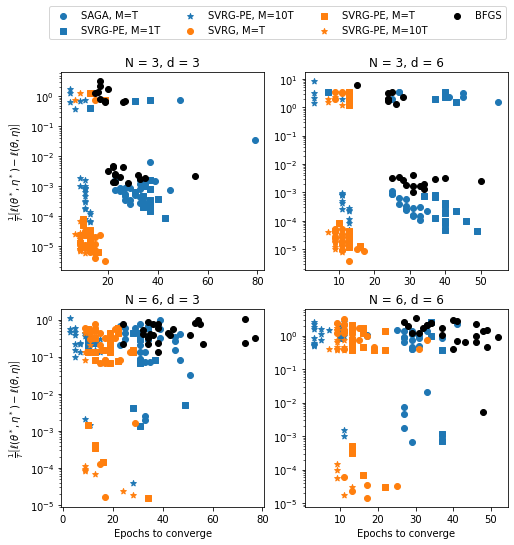

In [6]:
fig1, axs1 = plt.subplots(2,2,figsize=(8,8))

cmap = cm.get_cmap('tab10')
partial_Es = [0,0.5,1]

for T,K,d in product([100000],[[3,1],[6,1]],[3,6]):
    
    print(T,K,d)
    
    yind = int(K[0] == 6)#int(T == 100000)
    xind = int(d == 6) #+ 2*int(K[0] == 6)

    ll_star = []
    theta_star = []
    eta_star = []
    eta0_star = []
    
    epochs_to_converge = []
    times_to_converge = []
    lls = []
    
    for dataset in range(5):
        
        optims,lls0,epochs_to_converge0,times_to_converge0 = load_optims(T,K,d,dataset)
        
        ll_star.append(optims[("SAGA",0.0)].log_like_trace[-1])
        theta_star.append(optims[("SAGA",0.0)].theta)
        eta_star.append(optims[("SAGA",0.0)].eta)
        eta0_star.append(optims[("SAGA",0.0)].eta0)
        
        lls.append(lls0)
        epochs_to_converge.append(epochs_to_converge0)
        times_to_converge.append(times_to_converge0)
        
        for key in optims:

            print(key)
            if key[0] == 'control':
                continue
            print(optims[key].log_like_trace[-1])

            if ll_star[dataset] < optims[key].log_like_trace[-1]:

                print("control model has lower likelihood than a test model")

                update_ll = True
                for feature,k0,k1 in product(optims[key].features,range(optims[key].K[0]),range(optims[key].K[1])):
                    if optims[key].theta[k0][feature]['log_sig'][k1] < -5:
                        print("...but the test model has ~0 varaince. continuing...")
                        #update_ll = False
                        #break

                if update_ll:
                    ll_star[dataset] = optims[key].log_like_trace[-1]
                    theta_star[dataset] = optims[key].theta
                    eta_star[dataset] = optims[key].eta
                    eta0_star[dataset] = optims[key].eta0

    
    keys = [("SAGA",0.0),("SAGA",0.5),("SAGA",1.0),("SVRG",0.0),("SVRG",0.5),("SVRG",1.0),("BFGS",0.0)]
    
    # define linestyles
    linestyles = {("BFGS",0.0):("black","o"),
                  ("CG",0.0)  :("black","s"),
                  ("GD",0.0)  :("black","*"),
                  ("SAGA",0.0):(cmap(0),"o"),
                  ("SAGA",0.5):(cmap(0),"s"),
                  ("SAGA",1.0):(cmap(0),"*"),
                  ("SVRG",0.0):(cmap(1),"o"),
                  ("SVRG",0.5):(cmap(1),"s"),
                  ("SVRG",1.0):(cmap(1),"*")}
    
    # get data
    epochs_to_plot = []
    for key in keys:
        key_data = []
        for dataset in range(5):
            key_data.extend(epochs_to_converge[dataset][key])
        epochs_to_plot.append(key_data)
        
    lls_to_plot = []
    for key in keys:
        key_data = []
        for dataset in range(5):
            key_data.extend(ll_star[dataset] - lls[dataset][key])
        lls_to_plot.append(key_data)

    # plot data
    for key,epoch_data,ll_data in zip(keys,epochs_to_plot,lls_to_plot):
        axs1[yind,xind].scatter(epoch_data,ll_data,
                                color = linestyles[key][0],
                                marker = linestyles[key][1])
        
    # adjust axes
    axs1[yind,xind].set_yscale('log')
    if xind == 0:
        axs1[yind,xind].set_ylabel(r"$\frac{1}{T} \left[\ell(\theta^*, \eta^*) - \ell(\theta, \eta)\right]$")
    if yind == 1:
        axs1[yind,xind].set_xlabel("Epochs to converge")
    axs1[yind,xind].set_title("N = %d, d = %d" % (K[0],d))

legend_elem = {("BFGS",0.0): "BFGS",
               ("CG",0.0)  : "CG",
               ("GD",0.0)  : "GD",
               ("SVRG",0.0): "SVRG, M=T",
               ("SVRG",0.5): "SVRG-PE, M=T",
               ("SVRG",1.0): "SVRG-PE, M=10T",
               ("SAGA",0.0): "SAGA, M=T",
               ("SAGA",0.5): "SVRG-PE, M=1T",
               ("SAGA",1.0): "SVRG-PE, M=10T"}
# make legend
fig1.legend([legend_elem[key] for key in keys],loc='upper center', 
            bbox_to_anchor=(0.5, 1.0025),
            ncol=4)
    
fig1.show()

if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)

fig1.savefig(plot_folder + '/scatter_sim.png',dpi=500)

# Plot Results

In [83]:
T = 100000
K = [3,1]
d = 6
dataset = 1

cmap = cm.get_cmap('tab10')
partial_Es = [0,0.5,1]

1000 [3, 1] 3 0
('control', 0)
('BFGS', 0)
-1.60192660524163
control model has lower likelihood than a test model
('GD', 0)
-1.602166170655526
('CG', 0)
-1.6019267269546174
('SAGA', 0)
-1.6019270096248173
('SAGA', 0.5)
-1.6019270112194575
('SAGA', 1)
-1.6019270105848848
('SVRG', 0)
-1.6019270100980079
('SVRG', 0.5)
-1.6019270110012351
('SVRG', 1)
-1.6019270110074657


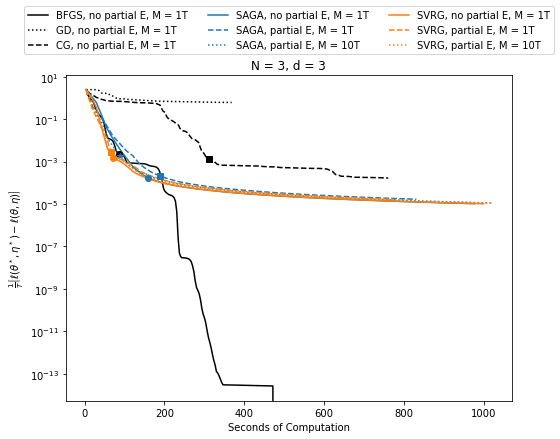

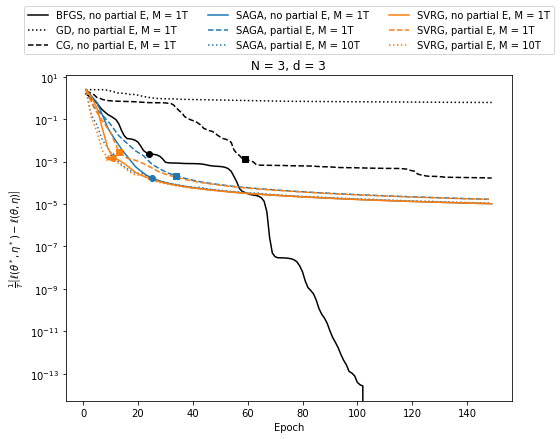

1000 [3, 1] 3 1
('control', 0)
('BFGS', 0)
-1.6262252781620379
control model has lower likelihood than a test model
('GD', 0)
-1.626444193874485
('CG', 0)
-1.62622534911193
('SAGA', 0)
-1.62622569776694
('SAGA', 0.5)
-1.6262256995314228
('SAGA', 1)
-1.6262256965507331
('SVRG', 0)
-1.626225696896503
('SVRG', 0.5)
-1.6262256996575277
('SVRG', 1)
-1.6262256980378542


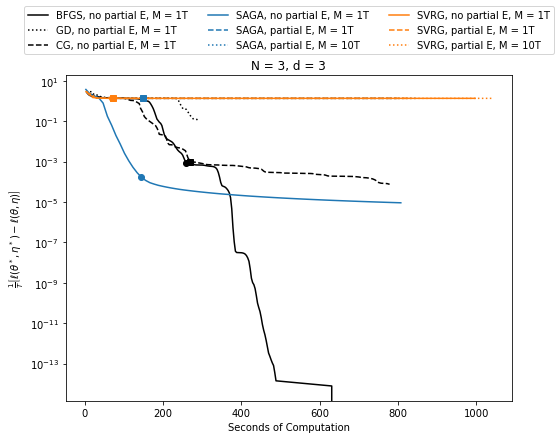

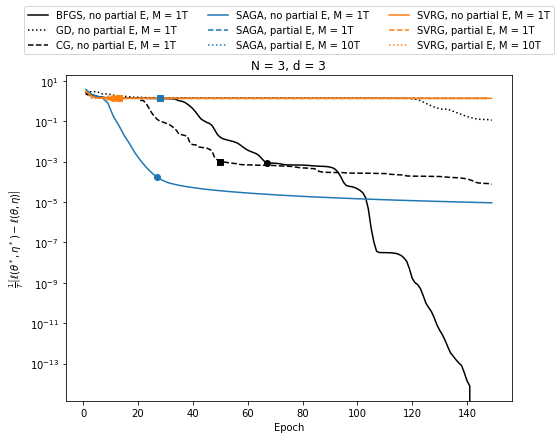

1000 [3, 1] 3 2
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-3-1_d-3_SVRG_0.5_000_002 does not exist
('control', 0)
('BFGS', 0)
-1.627191261191837
control model has lower likelihood than a test model
('GD', 0)
-1.6274035255882735
('CG', 0)
-1.627191418172581
('SAGA', 0)
-1.627191677118805
('SAGA', 0.5)
-1.6271916664446107
('SAGA', 1)
-1.627191664635664
('SVRG', 0)
-1.627191677972126
('SVRG', 0.5)
-1.6271916662932397
('SVRG', 1)
-1.6271916790710743


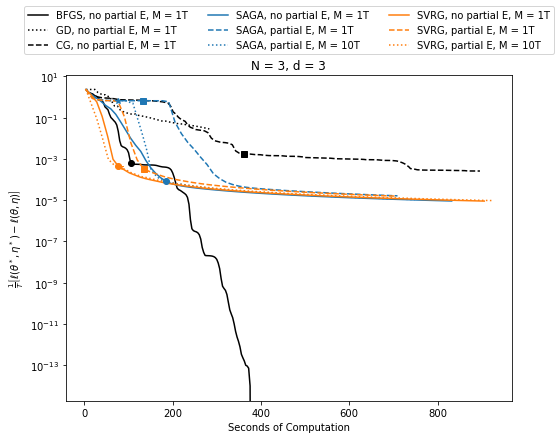

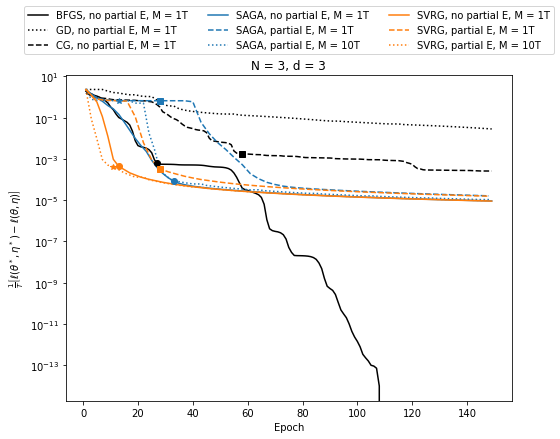

1000 [3, 1] 3 3
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-3-1_d-3_GD_0.0_000_003 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-3-1_d-3_SAGA_0.0_000_003 does not exist
('control', 0)
('BFGS', 0)
-1.6012610516773977
control model has lower likelihood than a test model
('GD', 0)
-1.601575976291258
('CG', 0)
-1.601261212192084
('SAGA', 0)
-1.6012614716371703
('SAGA', 0.5)
-1.6012614748323115
('SAGA', 1)
-1.6012614722827454
('SVRG', 0)
-1.6012614726327274
('SVRG', 0.5)
-1.6012614769257971
('SVRG', 1)
-1.6012614737157385


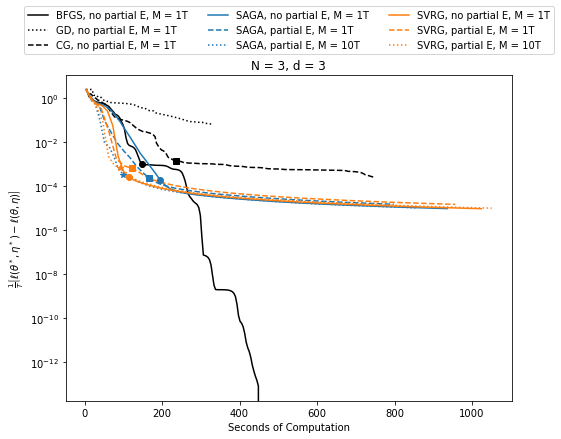

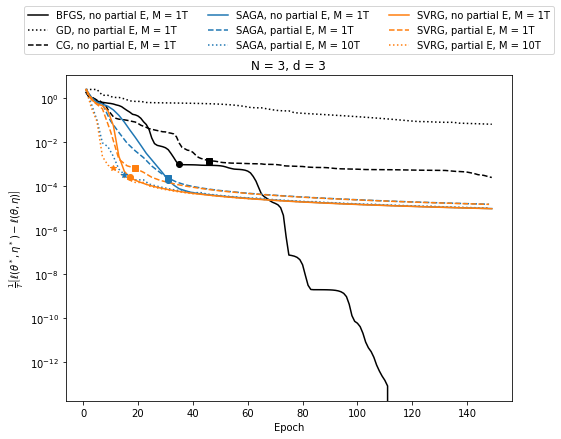

1000 [3, 1] 3 4
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-3-1_d-3_CG_0.0_000_004 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-3-1_d-3_SVRG_0.0_000_004 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-3-1_d-3_SVRG_0.5_000_004 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-3-1_d-3_SVRG_1.0_000_004 does not exist
('control', 0)
('BFGS', 0)
-1.5165580048650764
control model has lower likelihood than a test model
('GD', 0)
-1.51676652243354
('CG', 0)
-1.5165580513925372
('SAGA', 0)
-1.5165584129417171
('SAGA', 0.5)
-1.5165584237612098
('SAGA', 1)
-1.516558413487227
('SVRG', 0)
-1.5165584132170729
('SVRG', 0.5)
-1.5165584241190966
('SVRG', 1)
-1.5165584228612488


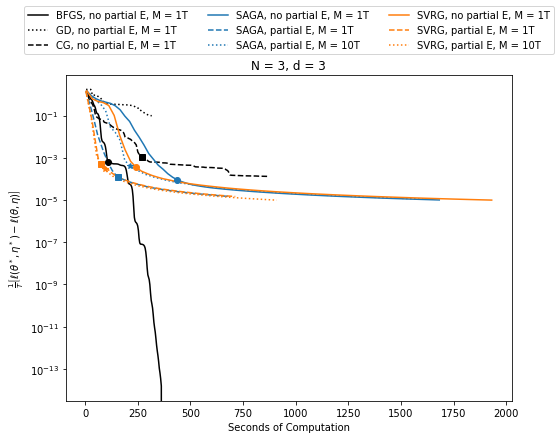

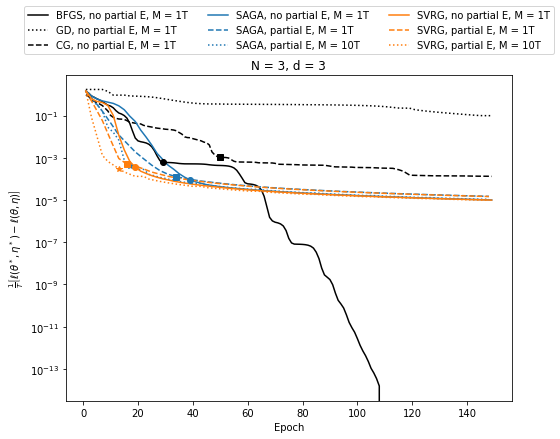

1000 [3, 1] 6 0
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-3-1_d-6_control_0.0_000_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-3-1_d-6_SAGA_1.0_000_000 does not exist
('control', 0)
('BFGS', 0)
-2.888879447869405
control model has lower likelihood than a test model
('GD', 0)
-2.889067501011866
('CG', 0)
-2.8888796461432817
('SAGA', 0)
-2.888879837524135
('SAGA', 0.5)
-2.8888798656228882
('SAGA', 1)
-2.8888798640625124
('SVRG', 0)
-2.888879837552514
('SVRG', 0.5)
-2.8888798646740974
('SVRG', 1)
-2.8888798769350377


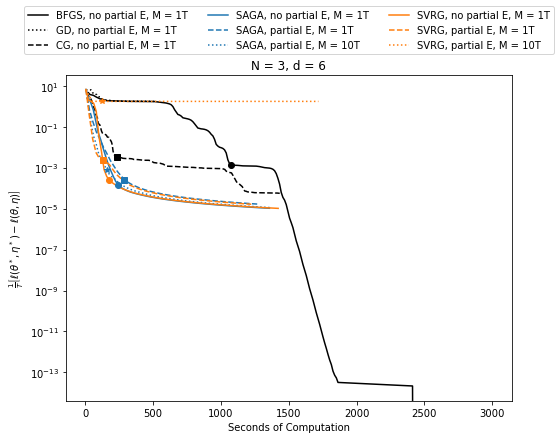

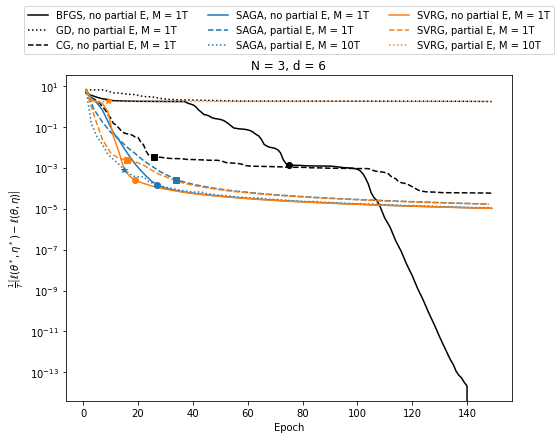

1000 [3, 1] 6 1
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-3-1_d-6_CG_0.0_000_001 does not exist
('control', 0)
('BFGS', 0)
-2.7655945116477696
control model has lower likelihood than a test model
('GD', 0)
-2.765829110328715
('CG', 0)
-2.7655946446620514
('SAGA', 0)
-2.7655949009160983
('SAGA', 0.5)
-2.765594926650053
('SAGA', 1)
-2.765594926384207
('SVRG', 0)
-2.7655949010092207
('SVRG', 0.5)
-2.765594926913586
('SVRG', 1)
-2.7655949216867377


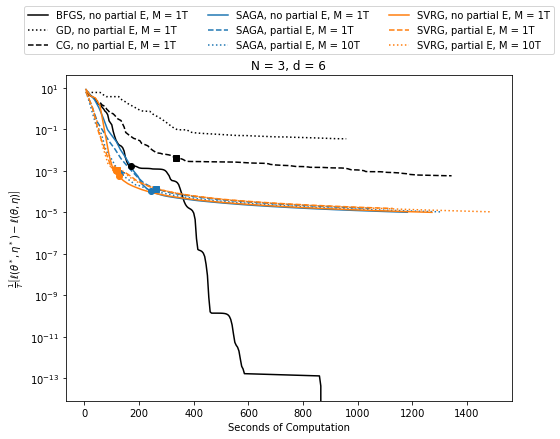

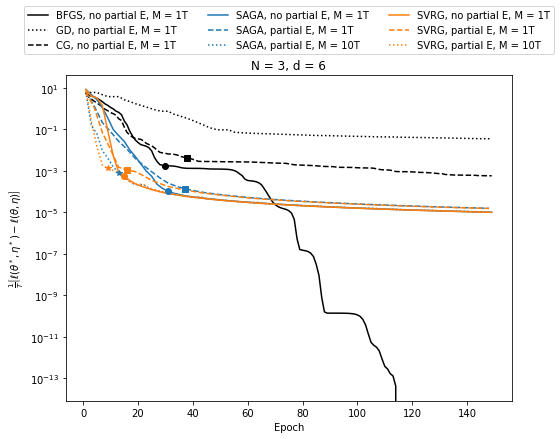

1000 [3, 1] 6 2
('control', 0)
('BFGS', 0)
-2.786631219863161
control model has lower likelihood than a test model
('GD', 0)
-2.7868567968196727
('CG', 0)
-2.7866314733133573
('SAGA', 0)
-2.786631615739331
('SAGA', 0.5)
-2.7866316223297187
('SAGA', 1)
-2.786631615717305
('SVRG', 0)
-2.786631615961724
('SVRG', 0.5)
-2.7866316160331963
('SVRG', 1)
-2.786631615749698


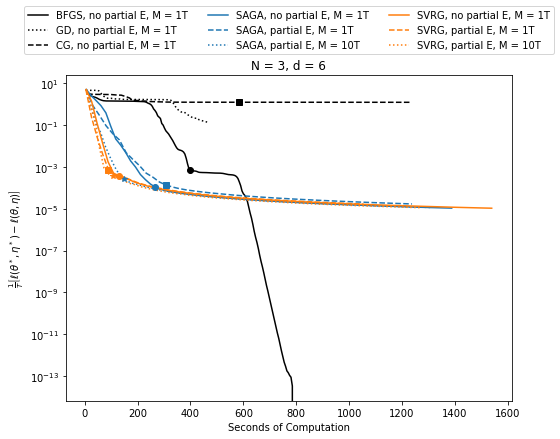

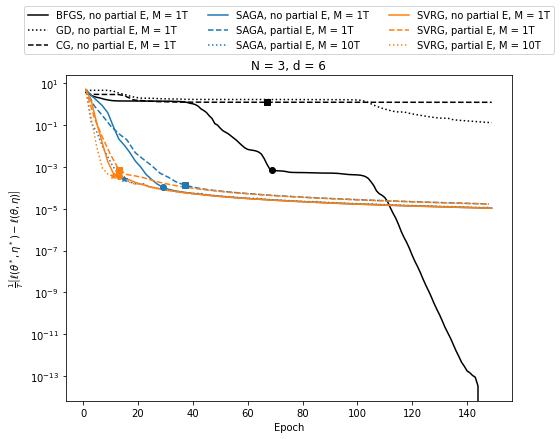

1000 [3, 1] 6 3
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-3-1_d-6_BFGS_0.0_000_003 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-3-1_d-6_SAGA_1.0_000_003 does not exist
('control', 0)
('BFGS', 0)
-2.84338217721349
control model has lower likelihood than a test model
('GD', 0)
-2.843850574648046
('CG', 0)
-2.8433826619738807
('SAGA', 0)
-2.84338258086707
('SAGA', 0.5)
-2.843382581713767
('SAGA', 1)
-2.843382581783779
('SVRG', 0)
-2.8433825808362934
('SVRG', 0.5)
-2.8433829127018564
('SVRG', 1)
-2.8433825810513826


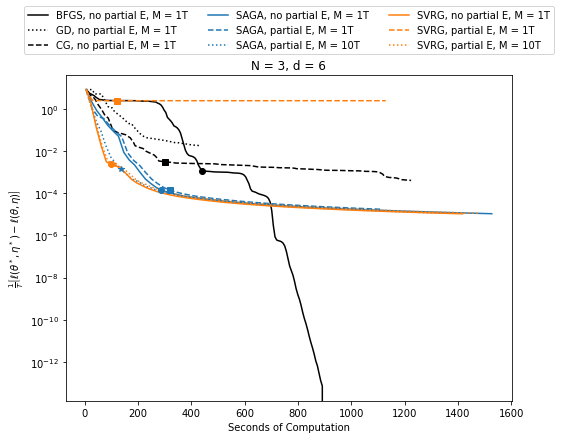

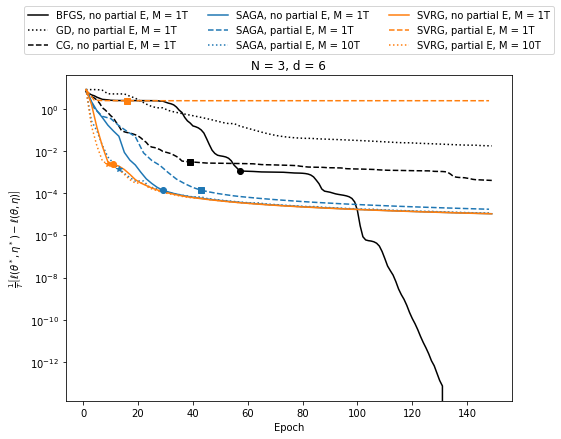

1000 [3, 1] 6 4
('control', 0)
('BFGS', 0)
-2.8591225167719516
control model has lower likelihood than a test model
('GD', 0)
-2.859337957753077
('CG', 0)
-2.8591226227534534
('SAGA', 0)
-2.8591229062810704
('SAGA', 0.5)
-2.859122906540393
('SAGA', 1)
-2.859122906125865
('SVRG', 0)
-2.8591229121082558
('SVRG', 0.5)
-2.8591229066920105
('SVRG', 1)
-2.8591229063375243


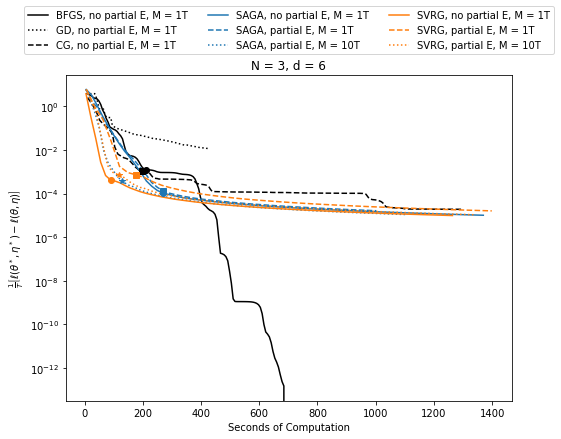

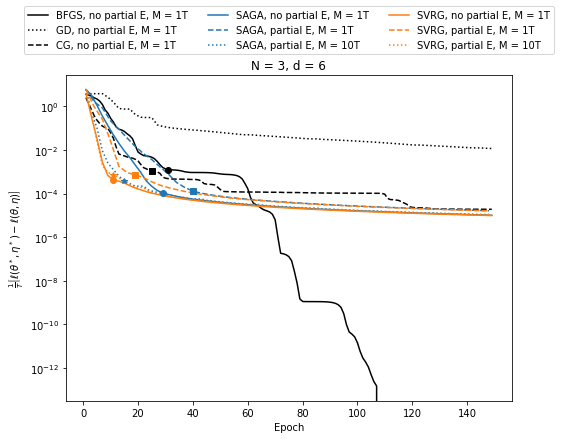

1000 [6, 1] 3 0
('control', 0)
('BFGS', 0)
-1.6500534519507837
control model has lower likelihood than a test model
('GD', 0)
-1.6509137373470224
('CG', 0)
-1.6500545549160204
('SAGA', 0)
-1.6501877977242458
('SAGA', 0.5)
-1.6501878457817065
('SAGA', 1)
-1.6501878306561868
('SVRG', 0)
-1.6501878095177869
('SVRG', 0.5)
-1.6501878568423953
('SVRG', 1)
-1.650187841516609


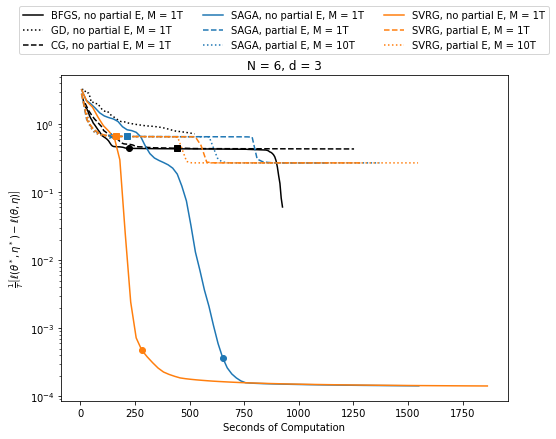

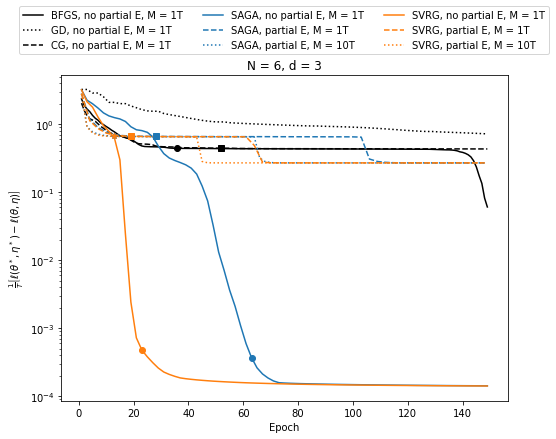

1000 [6, 1] 3 1
('control', 0)
('BFGS', 0)
-1.6819646920640319
control model has lower likelihood than a test model
('GD', 0)
-1.620382745420002
control model has lower likelihood than a test model
('CG', 0)
-1.6196660600113781
control model has lower likelihood than a test model
('SAGA', 0)
-1.6822429107516916
('SAGA', 0.5)
-1.6754620084012042
('SAGA', 1)
-1.6821178143835103
('SVRG', 0)
-1.6822431698682505
('SVRG', 0.5)
-1.6764146490602778
('SVRG', 1)
-1.6821178180827943


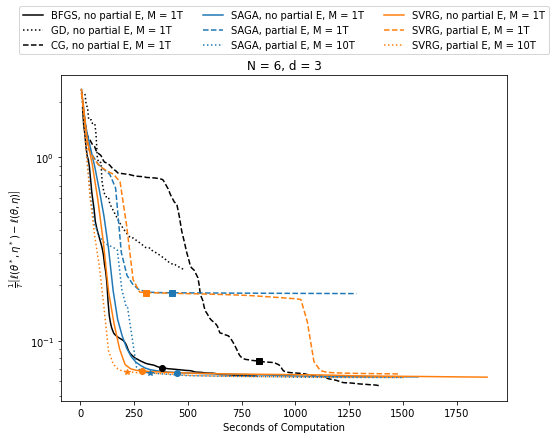

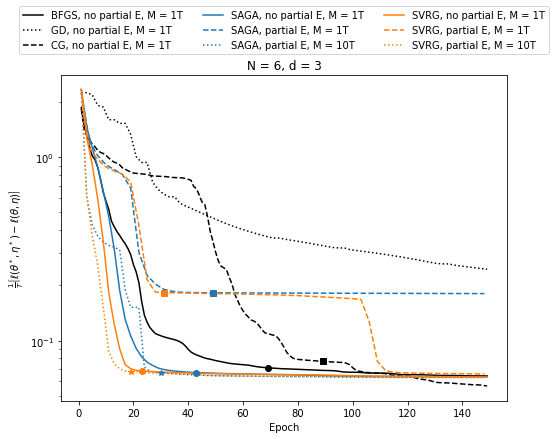

1000 [6, 1] 3 2
('control', 0)
('BFGS', 0)
-1.6650768112253749
control model has lower likelihood than a test model
('GD', 0)
-1.6832796320017671
('CG', 0)
-1.677158516780445
('SAGA', 0)
-1.6804577871202093
('SAGA', 0.5)
-1.6794110484372895
('SAGA', 1)
-1.6665726824320561
('SVRG', 0)
-1.6611043564832406
control model has lower likelihood than a test model
('SVRG', 0.5)
-1.6721516240074368
('SVRG', 1)
-1.6760360134938732


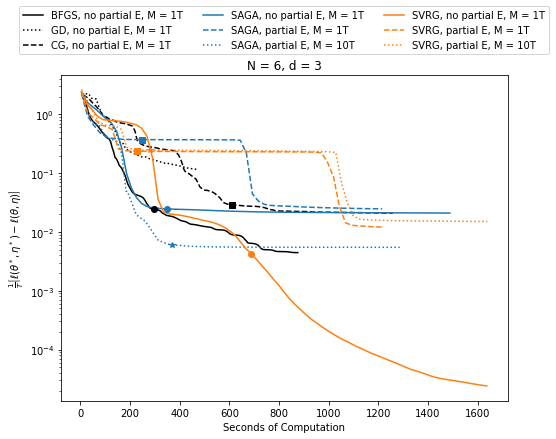

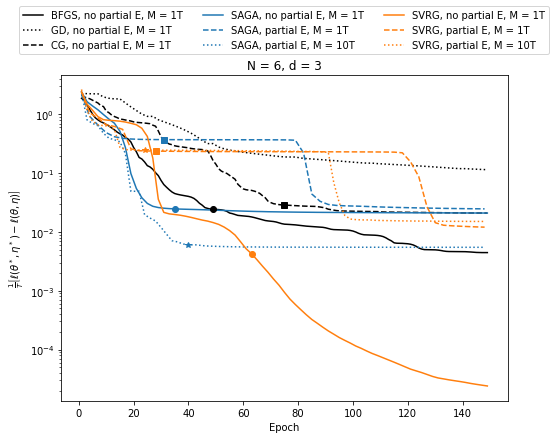

1000 [6, 1] 3 3
('control', 0)
('BFGS', 0)
-1.6475706183302052
control model has lower likelihood than a test model
('GD', 0)
-1.6482193290843825
('CG', 0)
-1.6475713548048994
('SAGA', 0)
-1.647664187094847
('SAGA', 0.5)
-1.6476641945601895
('SAGA', 1)
-1.647664180359223
('SVRG', 0)
-1.6476641955166567
('SVRG', 0.5)
-1.6476641978214597
('SVRG', 1)
-1.6476641936102412


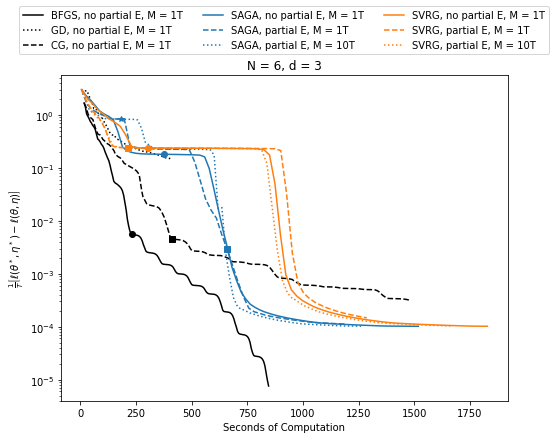

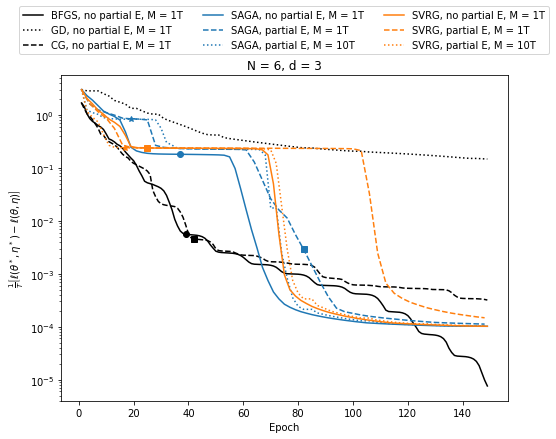

1000 [6, 1] 3 4
('control', 0)
('BFGS', 0)
-1.6734341630699814
control model has lower likelihood than a test model
('GD', 0)
-1.6754174481902995
('CG', 0)
-1.6065283001632478
control model has lower likelihood than a test model
('SAGA', 0)
-1.6736538657512967
('SAGA', 0.5)
-1.677329285009999
('SAGA', 1)
-1.67766725438648
('SVRG', 0)
-1.6773293000315828
('SVRG', 0.5)
-1.6773293087145904
('SVRG', 1)
-1.677854634186012


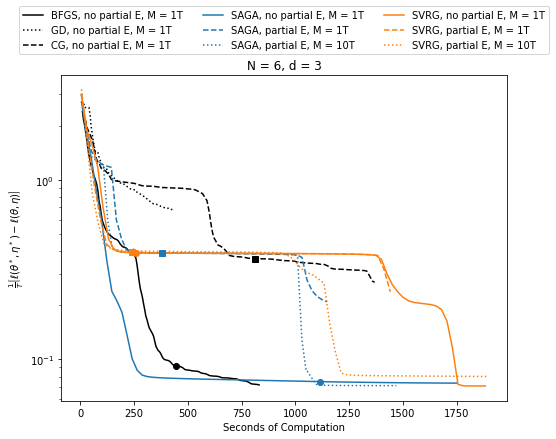

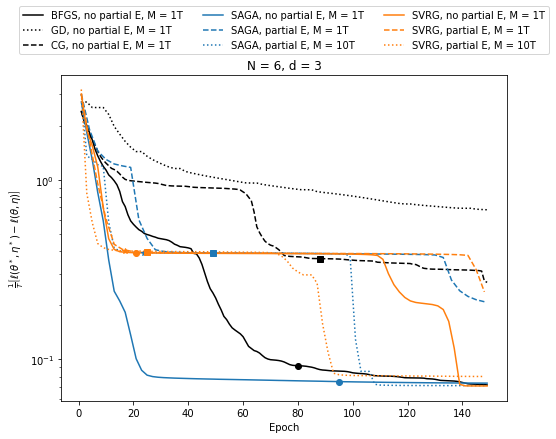

1000 [6, 1] 6 0
('control', 0)
('BFGS', 0)
-2.9550387782026473
control model has lower likelihood than a test model
('GD', 0)
-2.9558419574131674
('CG', 0)
-2.9550395939788947
('SAGA', 0)
-3.6000014361260946
('SAGA', 0.5)
-2.955086574866171
('SAGA', 1)
-2.9550865757606326
('SVRG', 0)
-3.5994715784915705
('SVRG', 0.5)
-3.600569526084113
('SVRG', 1)
-3.598812462381924


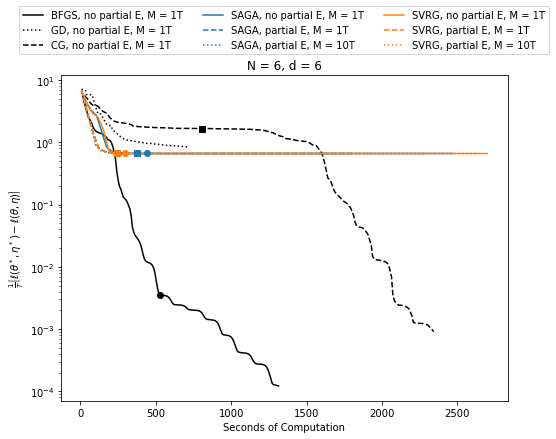

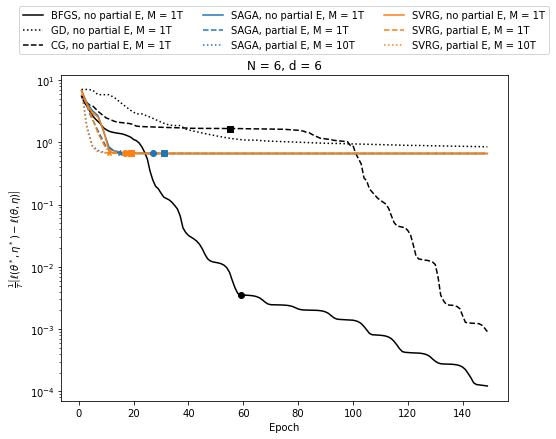

1000 [6, 1] 6 1
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-6-1_d-6_SAGA_0.5_000_001 does not exist
('control', 0)
('BFGS', 0)
-2.8128268324754164
control model has lower likelihood than a test model
('GD', 0)
-2.814578961616122
('CG', 0)
-2.81282843495797
('SAGA', 0)
-3.088835447315072
('SAGA', 0.5)
-3.0899920852178804
('SAGA', 1)
-3.087697210243455
('SVRG', 0)
-2.8130194553096213
('SVRG', 0.5)
-2.8130194661758066
('SVRG', 1)
-2.81301946405669


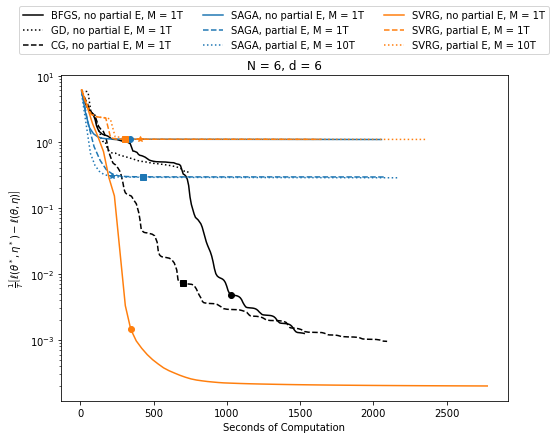

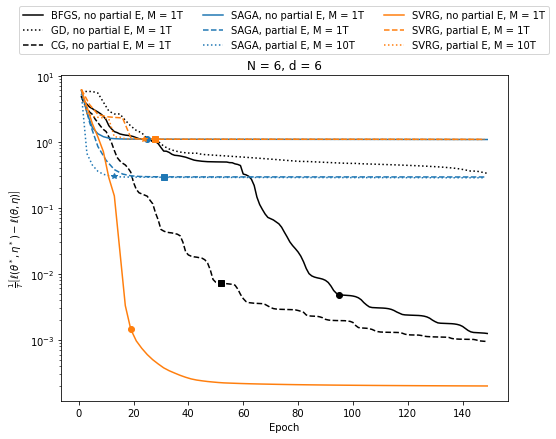

1000 [6, 1] 6 2
('control', 0)
('BFGS', 0)
-2.834761868556893
control model has lower likelihood than a test model
('GD', 0)
-2.8352647904911796
('CG', 0)
-2.8347625793984563
('SAGA', 0)
-2.834801811007944
('SAGA', 0.5)
-2.8348019788292316
('SAGA', 1)
-3.2218465982630256
('SVRG', 0)
-2.834801851168641
('SVRG', 0.5)
-2.8348019776364537
('SVRG', 1)
-2.8348019672558076


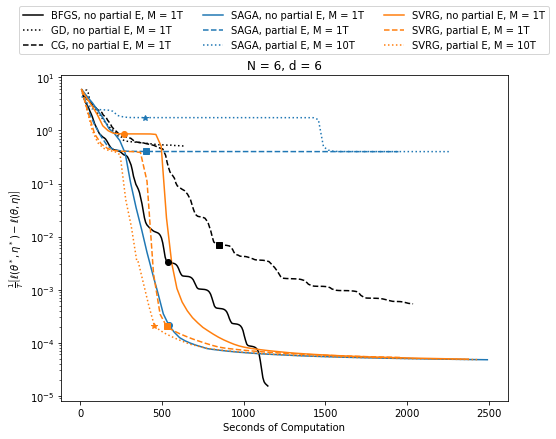

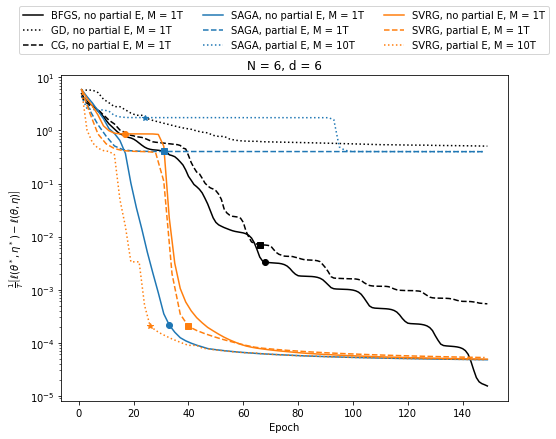

1000 [6, 1] 6 3
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-6-1_d-6_SAGA_0.5_000_003 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-6-1_d-6_SAGA_1.0_000_003 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-6-1_d-6_SVRG_0.0_000_003 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-6-1_d-6_SVRG_0.5_000_003 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-1000_K-6-1_d-6_SVRG_1.0_000_003 does not exist
('control', 0)
('BFGS', 0)
-2.884482449948472
control model has lower likelihood than a test model
('GD', 0)
-2.886135616943125
('CG', 0)
-2.88449362915964
('SAGA', 0)
-2.8845780825613945
('SAGA', 0.5)
-2.8845783752189953
('SAGA', 1)
-2.8845780142805455
('SVRG', 0)
-2.88457

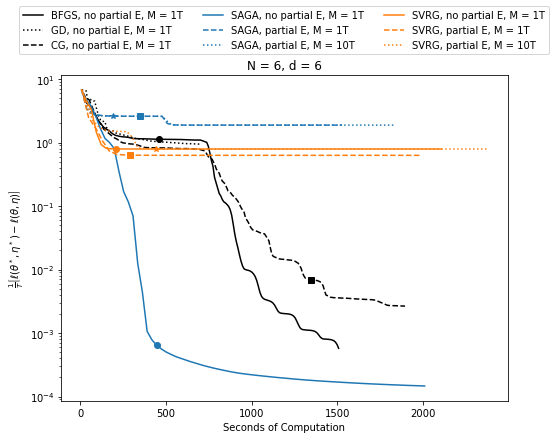

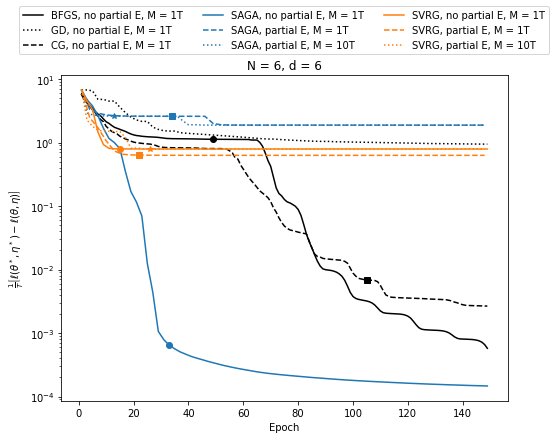

1000 [6, 1] 6 4
('control', 0)
('BFGS', 0)
-2.8934808142098634
control model has lower likelihood than a test model
('GD', 0)
-3.4367297132238095
('CG', 0)
-2.8934811199274386
('SAGA', 0)
-3.4226625825373405
('SAGA', 0.5)
-2.8934814012809738
('SAGA', 1)
-2.8934813980929417
('SVRG', 0)
-3.4257579644856033
('SVRG', 0.5)
-2.893481858769192
('SVRG', 1)
-2.8934814032115277


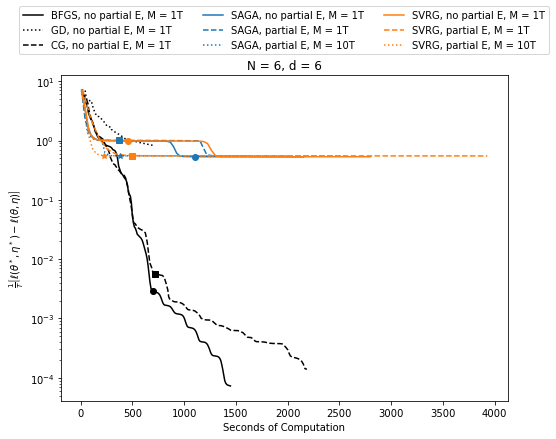

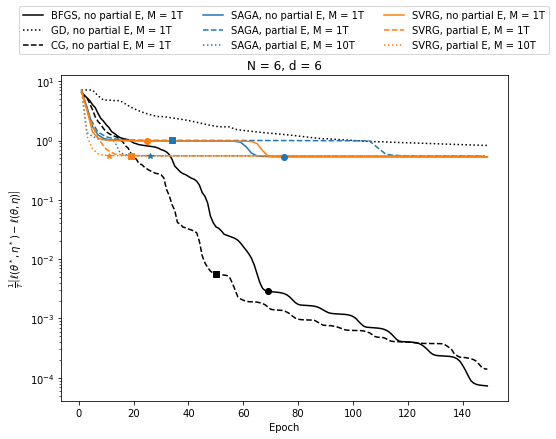

100000 [3, 1] 3 0
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_control_0.0_000_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_SAGA_0.5_002_000 does not exist
('control', 0)
('BFGS', 0)
-1.2656382874151177
control model has lower likelihood than a test model
('GD', 0)
-1.3532644295835576
('CG', 0)
-1.2656460567111472
('SAGA', 0)
-1.265638368402554
('SAGA', 0.5)
-1.2656383805294995
('SAGA', 1)
-1.265638357064062
('SVRG', 0)
-1.2656383750763356
('SVRG', 0.5)
-1.2656384146010038
('SVRG', 1)
-1.2656384069423914


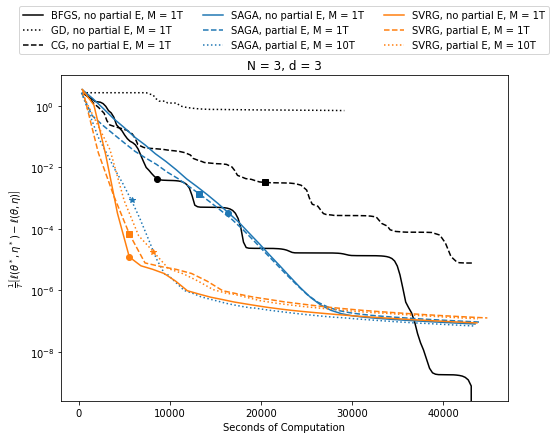

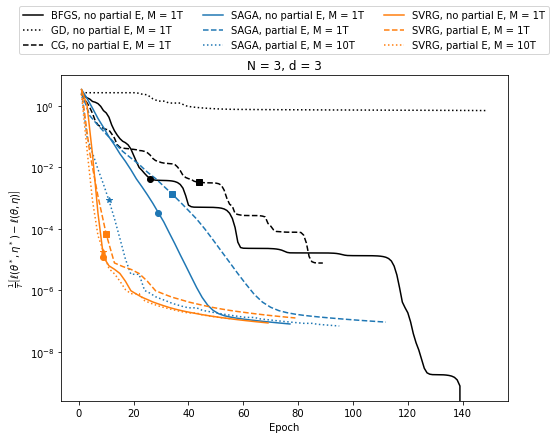

100000 [3, 1] 3 1
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_SAGA_0.5_001_001 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_SAGA_0.5_002_001 does not exist
('control', 0)
('BFGS', 0)
-1.2640298760567557
('GD', 0)
-1.3162531517501848
('CG', 0)
-1.264229035361682
('SAGA', 0)
-1.2640289160885074
('SAGA', 0.5)
-1.2640289244648542
('SAGA', 1)
-1.2640289118596764
control model has lower likelihood than a test model
('SVRG', 0)
-1.2640289114953216
control model has lower likelihood than a test model
('SVRG', 0.5)
-1.2640289417228965
('SVRG', 1)
-1.2640289315791347


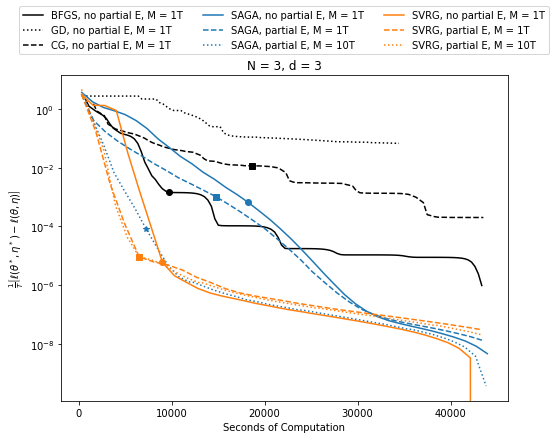

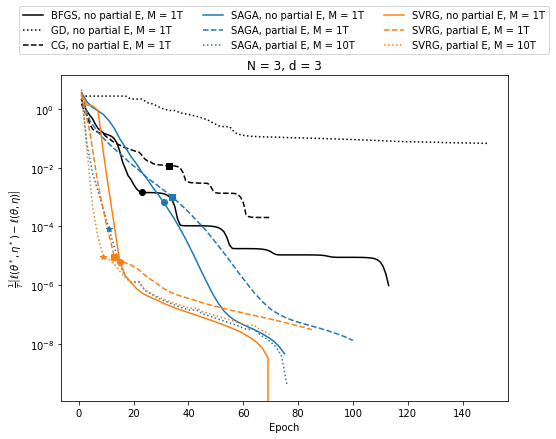

100000 [3, 1] 3 2
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_BFGS_0.0_000_002 does not exist
('control', 0)
('BFGS', 0)
-1.2626503374493125
('GD', 0)
-1.3171778645859842
('CG', 0)
-1.2626561472769446
('SAGA', 0)
-1.262648530954284
('SAGA', 0.5)
-1.2626485505877587
('SAGA', 1)
-1.2626485226339017
control model has lower likelihood than a test model
('SVRG', 0)
-1.262648541022825
('SVRG', 0.5)
-1.2626485640604834
('SVRG', 1)
-1.2626485355186696


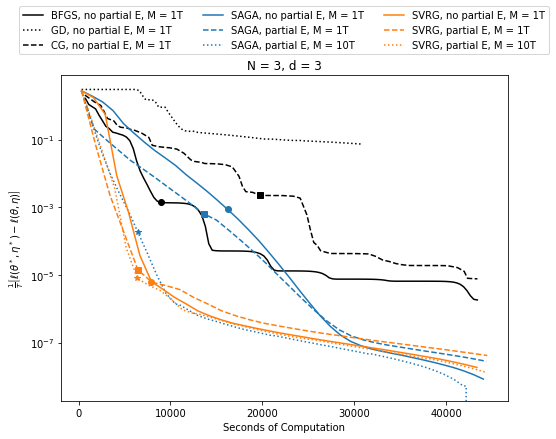

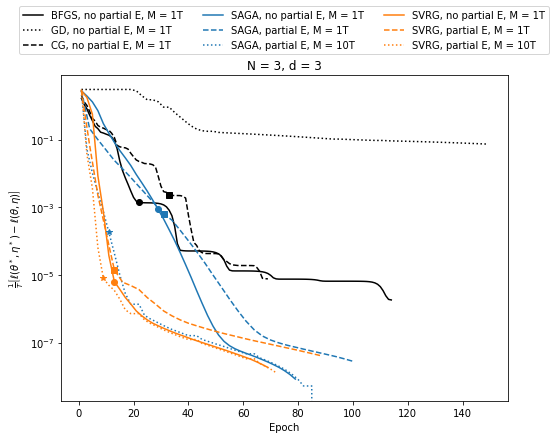

100000 [3, 1] 3 3
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_GD_0.0_000_003 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_CG_0.0_000_003 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_SAGA_0.5_000_003 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_SVRG_0.0_000_003 does not exist
('control', 0)
('BFGS', 0)
-1.2577702545615537
control model has lower likelihood than a test model
('GD', 0)
-1.2997662079226833
('CG', 0)
-1.258028994065425
('SAGA', 0)
-1.2577703440558832
('SAGA', 0.5)
-1.2577704089507395
('SAGA', 1)
-1.257770338745425
('SVRG', 0)
-1.2577703525289423
('SVRG', 0.5)
-1.2577703693890347
('SVRG', 1)
-1.257770359422013


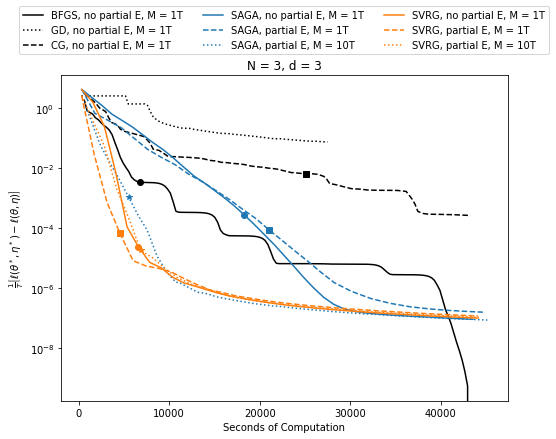

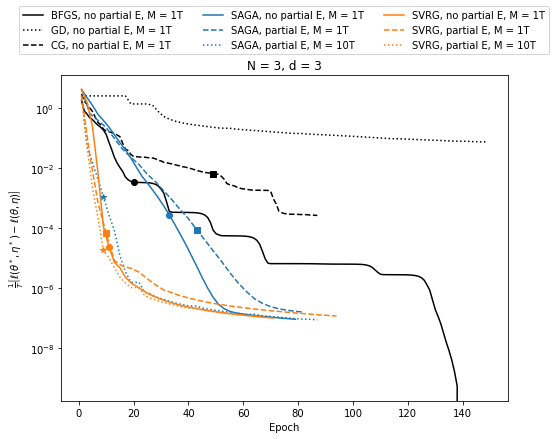

100000 [3, 1] 3 4
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_SAGA_1.0_000_004 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-3_SVRG_0.0_000_004 does not exist
('control', 0)
('BFGS', 0)
-1.264093649098411
control model has lower likelihood than a test model
('GD', 0)
-1.3129732489515789
('CG', 0)
-1.264100055502628
('SAGA', 0)
-1.2640937016364011
('SAGA', 0.5)
-1.264093723083627
('SAGA', 1)
-1.2640936864617853
('SVRG', 0)
-1.264093689442222
('SVRG', 0.5)
-1.2640937182597767
('SVRG', 1)
-1.264093699725629


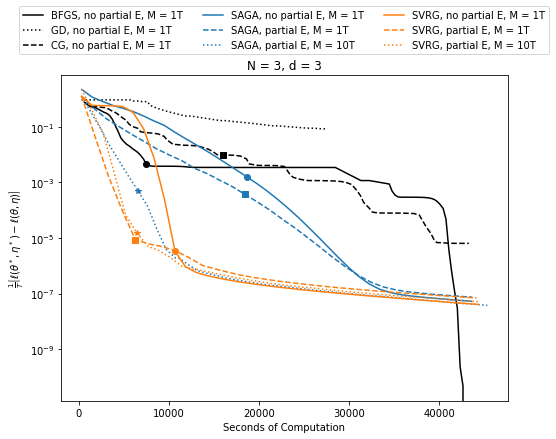

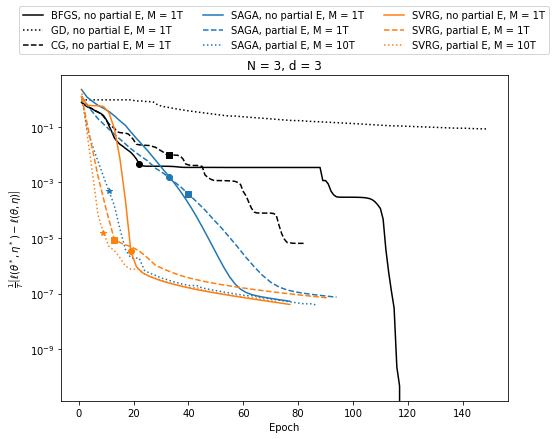

100000 [3, 1] 6 0
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_control_0.0_000_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_BFGS_0.0_000_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_GD_0.0_000_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_CG_0.0_000_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_SAGA_0.5_004_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_SAGA_1.0_000_000 does not exist
('control', 0)
('BFGS', 0)
-2.520615736902505
('GD', 0)
-2.6132969949978566
('CG', 0)
-2.522995507432397
('SAGA', 0)
-2

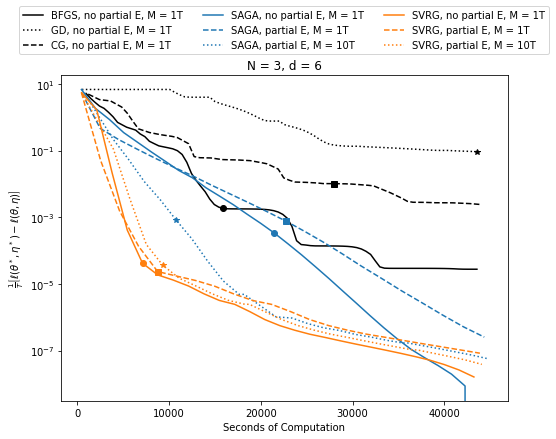

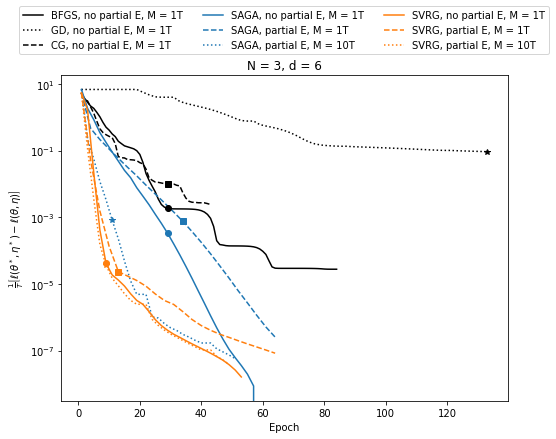

100000 [3, 1] 6 1
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_BFGS_0.0_001_001 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_SAGA_0.5_004_001 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_SAGA_1.0_004_001 does not exist
('control', 0)
('BFGS', 0)
-2.5167176424313187
('GD', 0)
-2.595057419512035
('CG', 0)
-2.5171575791749086
('SAGA', 0)
-2.5166880338455657
('SAGA', 0.5)
-2.5166920456435293
('SAGA', 1)
-2.51668801795788
control model has lower likelihood than a test model
('SVRG', 0)
-2.516687995165692
control model has lower likelihood than a test model
('SVRG', 0.5)
-2.5166880206141604
('SVRG', 1)
-2.516687966076035
control model has lower likelihood than a test model


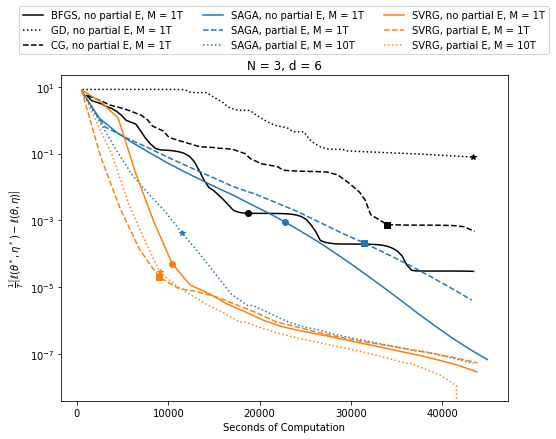

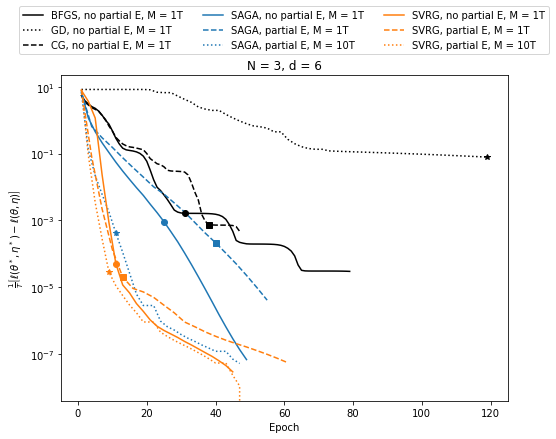

100000 [3, 1] 6 2
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_SAGA_0.0_000_002 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_SAGA_0.5_004_002 does not exist
('control', 0)
('BFGS', 0)
-2.5124899314407703
('GD', 0)
-2.578461665965919
('CG', 0)
-2.5125204360956412
('SAGA', 0)
-2.5124787272424847
('SAGA', 0.5)
-2.512478863107061
('SAGA', 1)
-2.5124787299969795
('SVRG', 0)
-2.5124787342086017
('SVRG', 0.5)
-2.5124788012590846
('SVRG', 1)
-2.5124787586624677


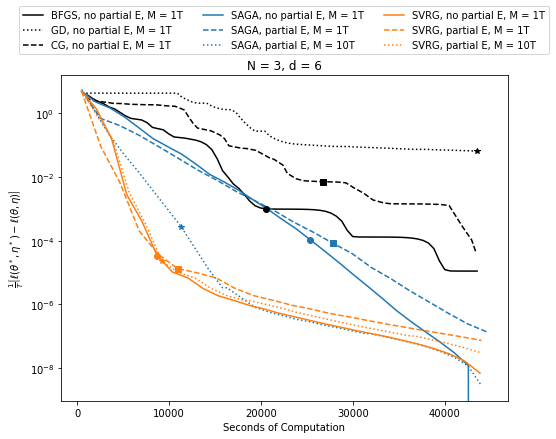

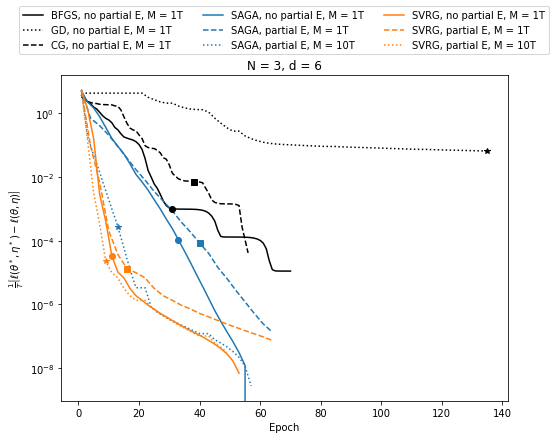

100000 [3, 1] 6 3
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_BFGS_0.0_001_003 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_SAGA_0.5_000_003 does not exist
('control', 0)
('BFGS', 0)
-2.5224221987295707
('GD', 0)
-2.589228810868368
('CG', 0)
-2.522608071114954
('SAGA', 0)
-2.522410709523672
('SAGA', 0.5)
-2.522412197271689
('SAGA', 1)
-2.522410733919348
('SVRG', 0)
-2.522410713085953
('SVRG', 0.5)
-2.5224109052290093
('SVRG', 1)
-2.5224107474004804


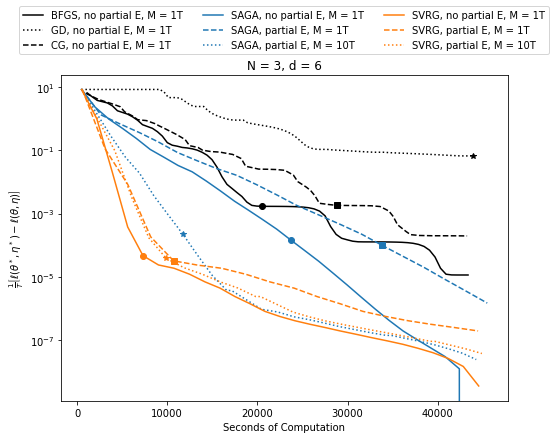

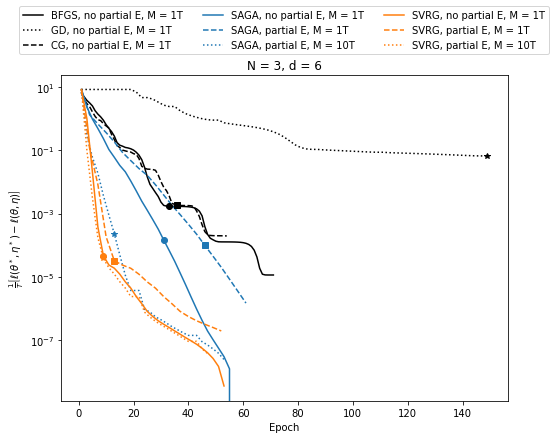

100000 [3, 1] 6 4
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_control_0.0_000_004 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_BFGS_0.0_000_004 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_GD_0.0_000_004 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_CG_0.0_000_004 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_SAGA_0.0_000_004 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_SAGA_0.5_000_004 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-3-1_d-6_SVRG_0.

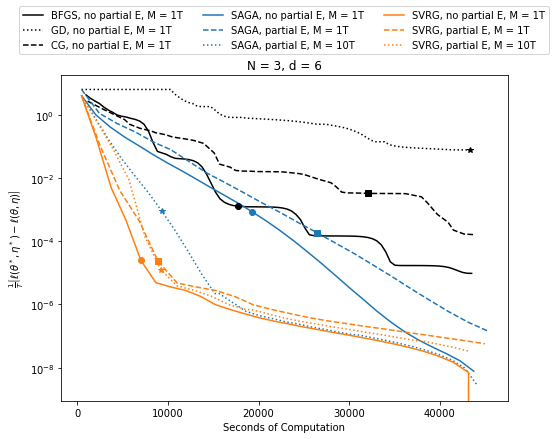

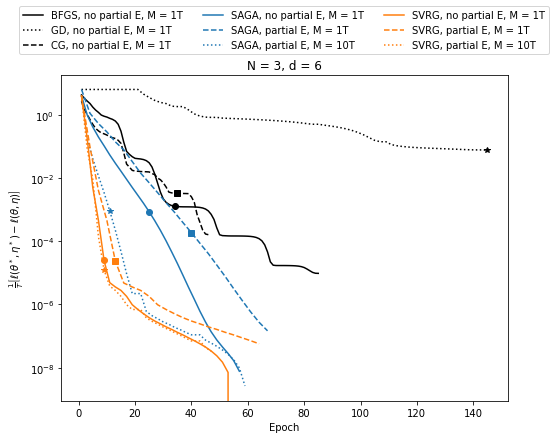

100000 [6, 1] 3 0
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_SAGA_0.5_002_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_SAGA_0.5_004_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_SAGA_1.0_000_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_SVRG_0.0_000_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_SVRG_0.5_000_000 does not exist
('control', 0)
('BFGS', 0)
-1.9951788911209727
('GD', 0)
-2.1889867220835475
('CG', 0)
-1.7155242027538615
('SAGA', 0)
-1.2665462003378254
('SAGA', 0.5)
-1.5888441785681349
('SAGA', 1)
-1.588796654309912
('SVRG', 0)
-1.2664703203165057
control model has lower li

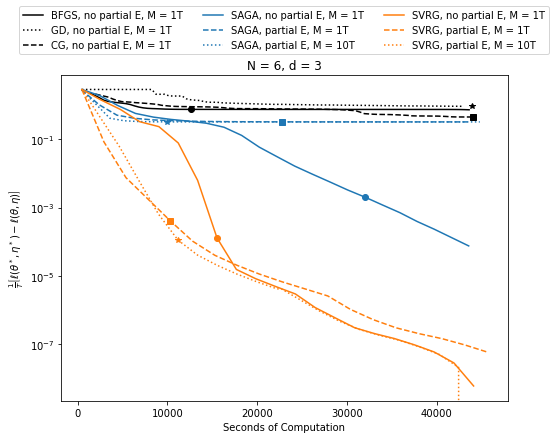

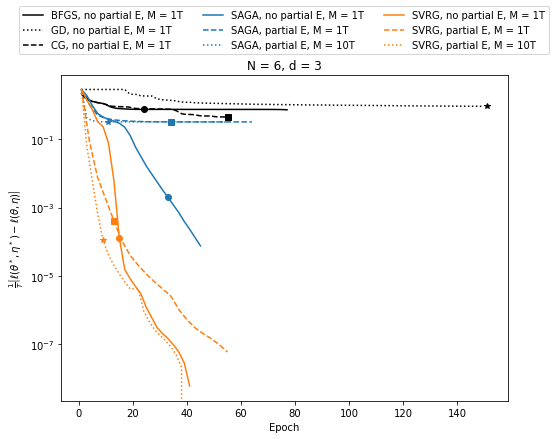

100000 [6, 1] 3 1
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_GD_0.0_000_001 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_SAGA_0.5_000_001 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_SAGA_0.5_001_001 does not exist
('control', 0)
('BFGS', 0)
-1.4810772490176363
('GD', 0)
-1.700109350823252
('CG', 0)
-1.4833302060222169
('SAGA', 0)
-1.2958812938044366
('SAGA', 0.5)
-1.332459311899108
('SAGA', 1)
-1.331559781492455
('SVRG', 0)
-1.2644704454175628
control model has lower likelihood than a test model
('SVRG', 0.5)
-1.2644706657795455
('SVRG', 1)
-1.3315567841579898


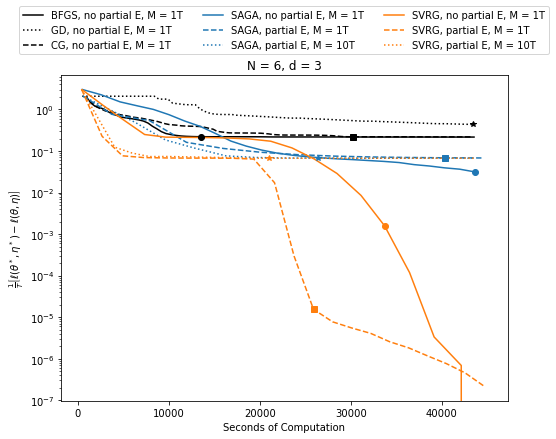

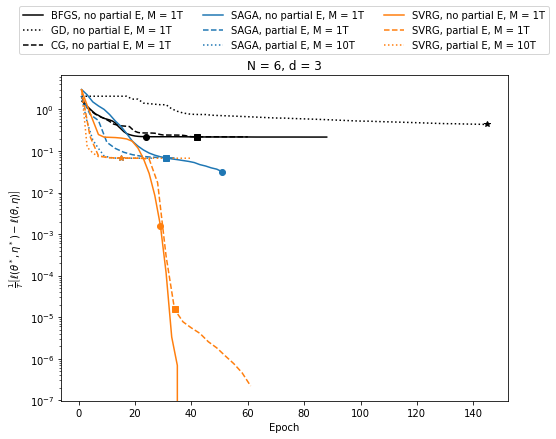

100000 [6, 1] 3 2
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_SAGA_0.5_001_002 does not exist
('control', 0)
('BFGS', 0)
-1.6469224623969319
('GD', 0)
-1.5714400635919632
('CG', 0)
-1.6557633947427244
('SAGA', 0)
-1.343392688648908
('SAGA', 0.5)
-1.3450903646067074
('SAGA', 1)
-1.2633378006838867
control model has lower likelihood than a test model
('SVRG', 0)
-1.3414700302466087
('SVRG', 0.5)
-1.2633376113848114
control model has lower likelihood than a test model
('SVRG', 1)
-1.2633375372416806
control model has lower likelihood than a test model


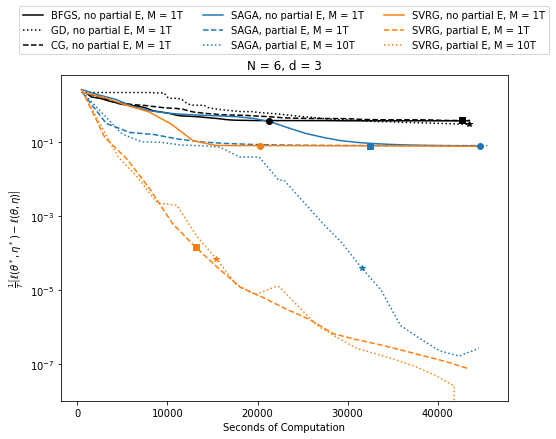

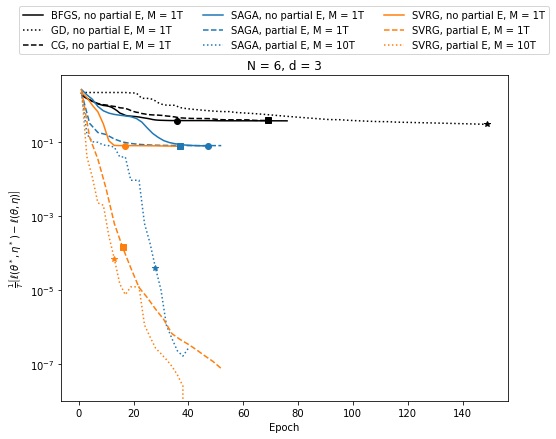

100000 [6, 1] 3 3
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_GD_0.0_000_003 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_CG_0.0_000_003 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_SAGA_1.0_000_003 does not exist
('control', 0)
('BFGS', 0)
-1.570115199920404
('GD', 0)
-1.8347813949377585
('CG', 0)
-1.299911460299332
('SAGA', 0)
-1.2592149389357448
('SAGA', 0.5)
-1.2592138223889948
control model has lower likelihood than a test model
('SAGA', 1)
-1.25921335364988
control model has lower likelihood than a test model
('SVRG', 0)
-1.2592142447661663
('SVRG', 0.5)
-1.2592134358876987
('SVRG', 1)
-1.2592134019825856


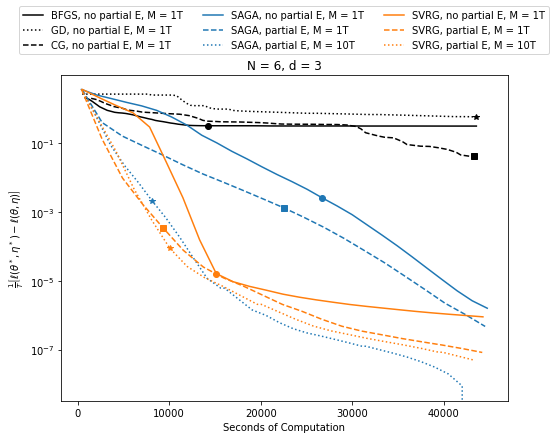

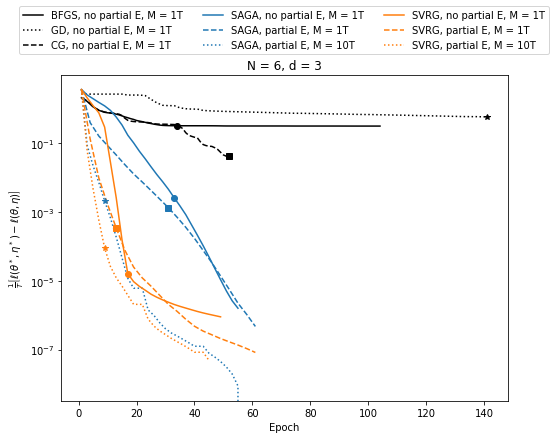

100000 [6, 1] 3 4
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_GD_0.0_000_004 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-3_SAGA_0.5_002_004 does not exist
('control', 0)
('BFGS', 0)
-1.400723458696677
('GD', 0)
-1.913971458102489
('CG', 0)
-1.4047742659157036
('SAGA', 0)
-1.3959237977136953
('SAGA', 0.5)
-1.2647572394810043
control model has lower likelihood than a test model
('SAGA', 1)
-1.2647528561490775
control model has lower likelihood than a test model
('SVRG', 0)
-1.3958827406095402
('SVRG', 0.5)
-1.2647529238196042
('SVRG', 1)
-1.2647529071516375


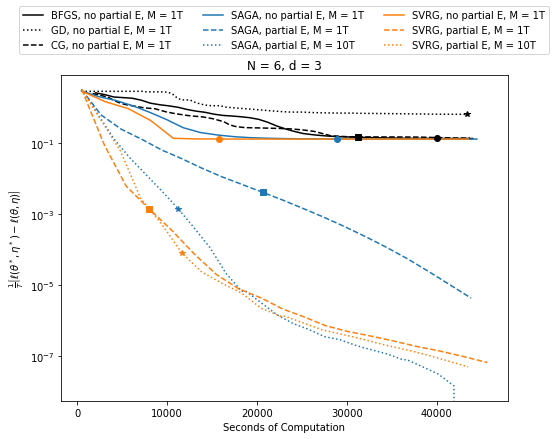

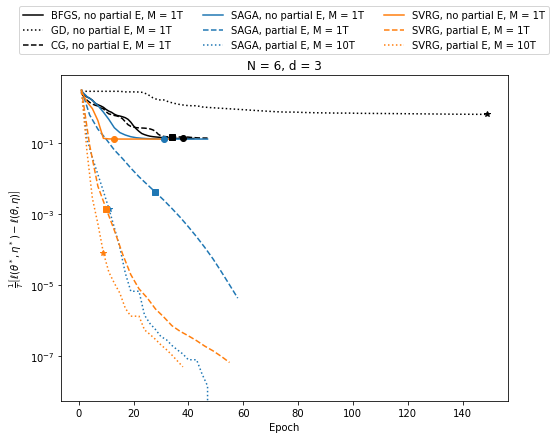

100000 [6, 1] 6 0
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_000_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_003_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_004_000 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_1.0_004_000 does not exist
('control', 0)
('BFGS', 0)
-3.503261211307277
('GD', 0)
-4.388653195326887
('CG', 0)
-3.6414594065386043
('SAGA', 0)
-2.521154715056899
('SAGA', 0.5)
-3.350656859668317
('SAGA', 1)
-3.270633232524338
('SVRG', 0)
-2.5209862726657146
control model has lower likelihood than a test model
('SVRG', 0.5)
-2.520987349067721
('SVRG', 1)
-2.5209866772596827


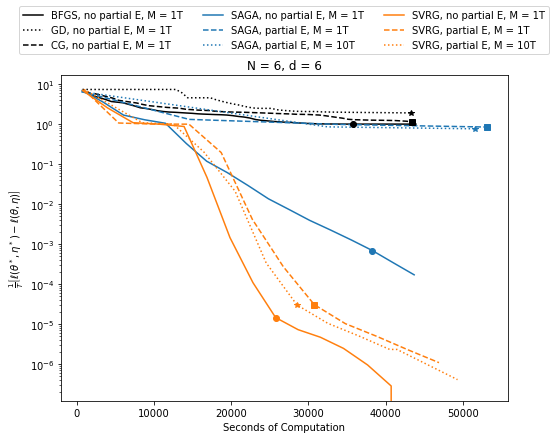

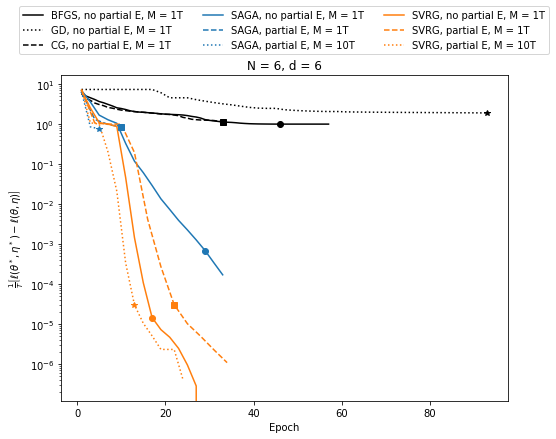

100000 [6, 1] 6 1
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_001_001 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_002_001 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_003_001 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_004_001 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_1.0_001_001 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_1.0_003_001 does not exist
('control', 0)
('BFGS', 0)
-2.9696066773047667
('GD', 0)
-3.721555381336919
('CG', 0)
-3.243086195216037
('SAGA', 0)
-

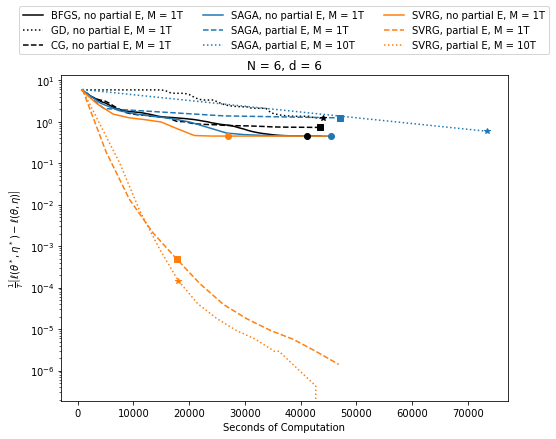

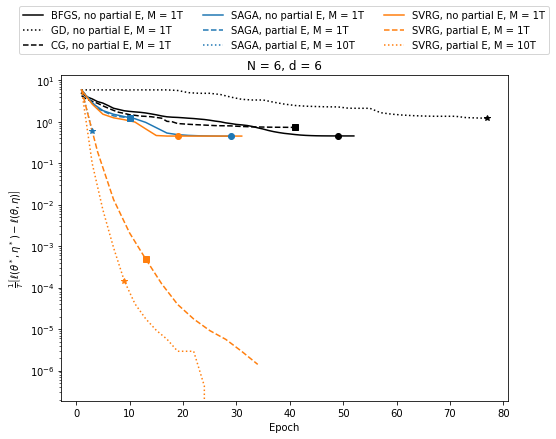

100000 [6, 1] 6 2
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_000_002 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_001_002 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_002_002 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_003_002 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_1.0_003_002 does not exist
('control', 0)
('BFGS', 0)
-2.5184590356738514
('GD', 0)
-3.0237869581592087
('CG', 0)
-2.6457562839737507
('SAGA', 0)
-2.5179128352084716
('SAGA', 0.5)
-2.5135392719644325
control model has lower likelihood than a test model
('SAGA', 1)
-2.5133246533626523
cont

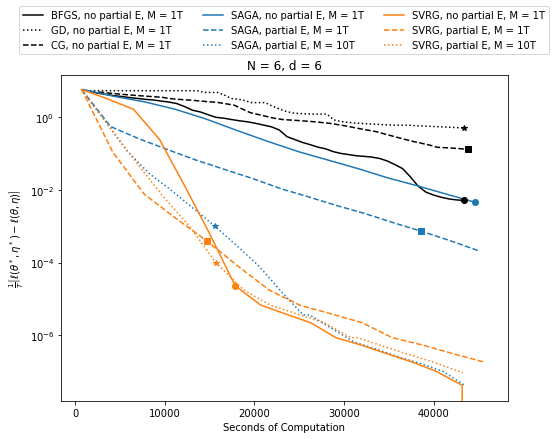

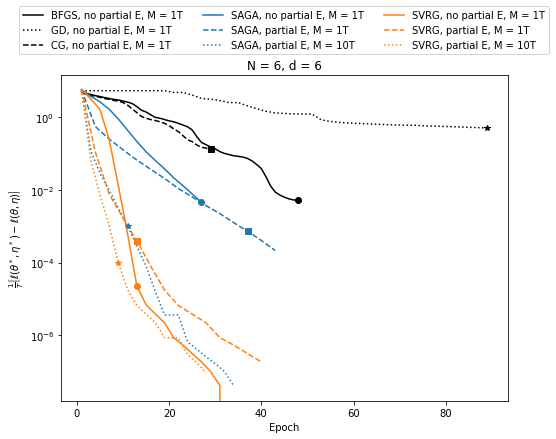

100000 [6, 1] 6 3
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_000_003 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_001_003 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_003_003 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_1.0_003_003 does not exist
('control', 0)
('BFGS', 0)
-3.5966728547076277
('GD', 0)
-3.7100390033047943
('CG', 0)
-3.64991383652258
('SAGA', 0)
-2.5234780628247218
('SAGA', 0.5)
-2.5238608326730523
('SAGA', 1)
-2.523233335179387
control model has lower likelihood than a test model
('SVRG', 0)
-2.523233538158487
('SVRG', 0.5)
-2.5232326808464167
control model has lower likelihood than a test model
('SVRG', 1)
-2.5232324119401435
c

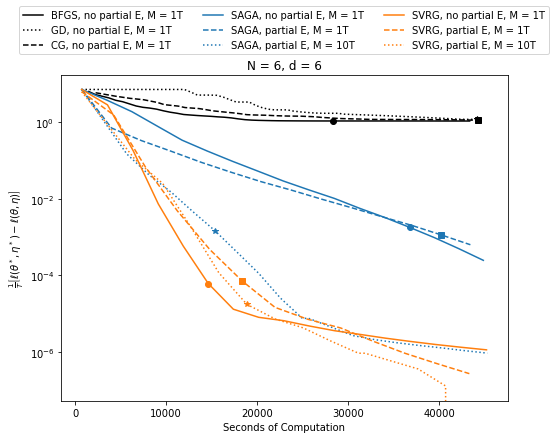

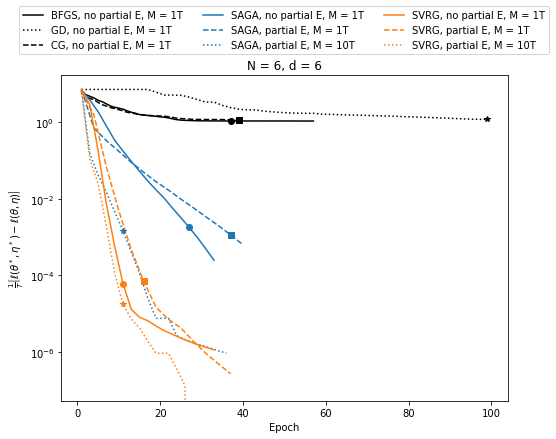

100000 [6, 1] 6 4
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_003_004 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_0.5_004_004 does not exist
file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/Oct-25-2022/T-100000_K-6-1_d-6_SAGA_1.0_003_004 does not exist
('control', 0)
('BFGS', 0)
-3.453118267677475
('GD', 0)
-3.5939898510620285
('CG', 0)
-3.8223045491678658
('SAGA', 0)
-2.529746461106761
('SAGA', 0.5)
-2.905483148246139
('SAGA', 1)
-2.905262762084986
('SVRG', 0)
-2.52260299534408
control model has lower likelihood than a test model
('SVRG', 0.5)
-2.9052684568452904
('SVRG', 1)
-2.9053322721809614


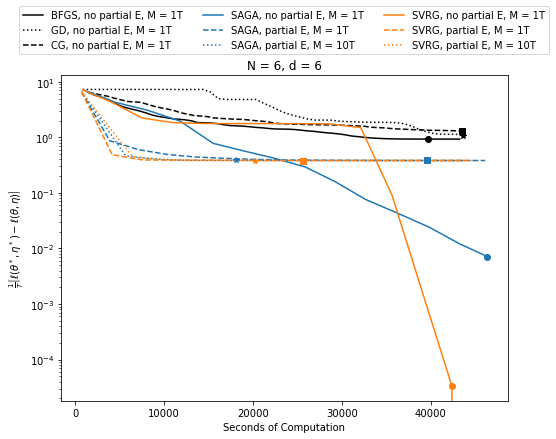

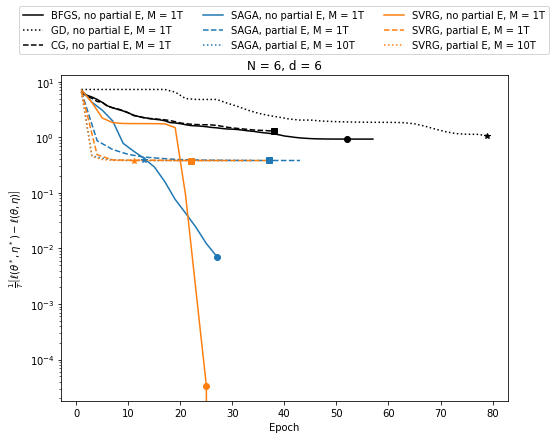

In [92]:
for T in [1000,100000]:
    for K in [[3,1],[6,1]]:
        for d in [3,6]:
            for dataset in range(5):
                
                print (T,K,d,dataset)

                optims,lls,epochs_to_converge,times_to_converge = load_optims(T,K,d,dataset)

                cmap = cm.get_cmap('tab10')

                linestyles = {("BFGS",0.0):("black","-"),
                              ("CG",0.0)  :("black","--"),
                              ("GD",0.0)  :("black",":"),
                              ("SAGA",0.0):(cmap(0),"-"),
                              ("SAGA",0.5):(cmap(0),"--"),
                              ("SAGA",1.0):(cmap(0),":"),
                              ("SVRG",0.0):(cmap(1),"-"),
                              ("SVRG",0.5):(cmap(1),"--"),
                              ("SVRG",1.0):(cmap(1),":")}

                pointstyles = {("BFGS",0.0):("black","o"),
                               ("CG",0.0)  :("black","s"),
                               ("GD",0.0)  :("black","*"),
                               ("SVRG",0.0):(cmap(1),"o"),
                               ("SVRG",0.5):(cmap(1),"s"),
                               ("SVRG",1.0):(cmap(1),"*"),
                               ("SAGA",0.0):(cmap(0),"o"),
                               ("SAGA",0.5):(cmap(0),"s"),
                               ("SAGA",1.0):(cmap(0),"*")}

                ll_star = optims[("SAGA",0.0)].log_like_trace[-1]
                theta_star = optims[("SAGA",0.0)].theta
                eta_star = optims[("SAGA",0.0)].eta
                eta0_star = optims[("SAGA",0.0)].eta0

                for key in optims:

                    print(key)
                    if key[0] == 'control':
                        continue
                    print(optims[key].log_like_trace[-1])

                    if ll_star < optims[key].log_like_trace[-1]:

                        print("control model has lower likelihood than a test model")

                        update_ll = True
                        for feature,k0,k1 in product(optims[key].features,range(optims[key].K[0]),range(optims[key].K[1])):
                            if optims[key].theta[k0][feature]['log_sig'][k1] < -5:
                                print("...but the test model has ~0 varaince. continuing...")
                                #update_ll = False
                                #break

                        if update_ll:
                            ll_star = optims[key].log_like_trace[-1]
                            theta_star = optims[key].theta
                            eta_star = optims[key].eta
                            eta0_star = optims[key].eta0

                plot_ll(optims,x_time=True)#,xlims=[0,600],ylims=[1e-4,1e1])
                plot_ll(optims,x_time=False)#,xlims=[0,100],ylims=[1e-4,1e1])

In [86]:
def find_perm(optim,eta_star,theta_star):
    
    # get the coarse-scale permutation of states
    cost_matrix = np.zeros((optim.K[0],optim.K[0]))
    
    # get the coarse-scale permutation
    Gamma_coarse_star = np.exp(eta_2_log_Gamma(eta_star)[0])
    Gamma_fine_star = np.exp(eta_2_log_Gamma(eta_star)[1])

    Gamma_coarse_optm = np.exp(eta_2_log_Gamma(optim.eta)[0])
    Gamma_fine_optm = np.exp(eta_2_log_Gamma(optim.eta)[1])

    # get the trace of each fine-scale ptm
    for k0_star in range(optim.K[0]):
        square_dists = np.zeros(optim.K[0])
        for k0_optm in range(optim.K[0]):
            square_dists[k0_optm] += (Gamma_coarse_star[k0_star,k0_star] - \
                                      Gamma_coarse_optm[k0_optm,k0_optm])**2 
            square_dists[k0_optm] += (np.trace(Gamma_fine_star[k0_star]) - \
                                      np.trace(Gamma_fine_optm[k0_optm]))**2 

        cost_matrix[k0_star] = square_dists

    star_states_coarse, optim_states_coarse = linear_sum_assignment(cost_matrix)

    # get the fine-scale permutations
    star_states_fine = [None for _ in range(optim.K[0])]
    optim_states_fine = [None for _ in range(optim.K[0])]

    for k0_star in range(optim.K[0]):
        k0_optm = optim_states_coarse[k0_star]

        # get the fine-scale permutation of states
        cost_matrix = np.zeros((optim.K[1],optim.K[1]))

        # get the fine-scale permutation
        Gamma_fine_star = np.exp(eta_2_log_Gamma(eta_star)[1][k0_star])
        Gamma_fine_optm = np.exp(eta_2_log_Gamma(optim.eta)[1][k0_optm])

        for k1_star in range(optim.K[1]):
            square_dists = np.zeros(optim.K[1])
            for k1_optm in range(optim.K[1]):
                for feature in optim.features:
                    square_dists[k1_optm] += (theta_star[k0_star][feature]['mu'][k1_star] - \
                                              optim.theta[k0_optm][feature]['mu'][k1_optm])**2 
                    square_dists[k1_optm] += (np.exp(theta_star[k0_star][feature]['log_sig'][k1_star]) - \
                                              np.exp(optim.theta[k0_optm][feature]['log_sig'][k1_optm]))**2 
                square_dists[k1_optm] += (Gamma_fine_star[k1_star,k1_star] - \
                                          Gamma_fine_optm[k1_optm,k1_optm])**2 

            cost_matrix[k1_star] = square_dists

        star_states_fine[k0_star], optim_states_fine[k0_optm] = linear_sum_assignment(cost_matrix)

    return optim_states_coarse,optim_states_fine

In [87]:
def find_distances(optim,theta_star,eta_star,eta0_star):

    # get permutation
    optim_states_coarse,optim_states_fine = find_perm(optim,eta_star,theta_star)
    
    # now get distances
    square_dists = np.zeros(len(optim.epoch_trace))

    Gamma_coarse_star = np.exp(eta_2_log_Gamma(eta_star)[0])
    Gamma_fine_star = np.exp(eta_2_log_Gamma(eta_star)[1])

    delta_coarse_star = np.exp(eta0_2_log_delta(eta0_star)[0])
    delta_fine_star = np.exp(eta0_2_log_delta(eta0_star)[1])

    for i in range(len(optim.epoch_trace)):

        # add theta
        for k0_star in range(optim.K[0]):
            k0_optm = optim_states_coarse[k0_star]
            for k1_star in range(optim.K[1]):
                k1_optm = optim_states_fine[k0_optm][k1_star]
                for feature in optim.features:
                    square_dists[i] += (theta_star[k0_star][feature]['mu'][k1_star] - \
                                        optim.theta_trace[i][k0_optm][feature]['mu'][k1_optm])**2 
                    square_dists[i] += (np.exp(theta_star[k0_star][feature]['log_sig'][k1_star]) - \
                                        np.exp(optim.theta_trace[i][k0_optm][feature]['log_sig'][k1_optm]))**2 

        
        # get Gamma and delta
        Gamma_coarse_optm = np.exp(eta_2_log_Gamma(optim.eta_trace[i])[0])
        Gamma_fine_optm = np.exp(eta_2_log_Gamma(optim.eta_trace[i])[1])

        delta_coarse_optm = np.exp(eta0_2_log_delta(optim.eta0_trace[i])[0])
        delta_fine_optm = np.exp(eta0_2_log_delta(optim.eta0_trace[i])[1])

        # add coarse Gamma and delta
        for i_star in range(optim.K[0]):
            i_optm = optim_states_coarse[i_star]

            for j_star in range(optim.K[0]):
                j_optm = optim_states_coarse[j_star]

                square_dists[i] += (Gamma_coarse_star[i_star,j_star] - \
                                    Gamma_coarse_optm[i_optm,j_optm])**2

            # BUG IN CODE NEED TO FIX :(
            #square_dists[i] += (delta_coarse_star[i_star] - \
            #                    delta_coarse_optm[i_optm])**2
            

        # add fine Gamma and delta
        for k0_star in range(optim.K[0]):
            k0_optm = optim_states_coarse[k0_star]

            for i_star in range(optim.K[1]):
                i_optm = optim_states_fine[k0_optm][i_star]

                for j_star in range(optim.K[1]):
                    j_optm = optim_states_fine[k0_optm][j_star]

                    square_dists[i] += (Gamma_fine_star[k0_star][i_star,j_star] - \
                                        Gamma_fine_optm[k0_optm][i_optm,j_optm])**2

                # BUG IN CODE NEED TO FIX :(
                #square_dists[i] += (delta_fine_star[k0_star][i_star] - \
                #delta_fine_optm[k0_optm][i_optm])**2
                
    return square_dists

In [88]:
def plot_dists(optims,theta_star,eta_star,eta0_star,x_time=False,xlims=None,ylims=None):
    
    legend = []
    plt.figure(figsize=(8,6))
    
    for method in methods:
        
        if method == "control":
            continue
        
        for partial_E in [0,0.5,1]:
            
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            
            if (method,partial_E) in optims:
                
                optim = optims[(method,partial_E)]
                lcol = linestyles[(method,partial_E)][0]
                ltyp = linestyles[(method,partial_E)][1]
                
                dists = find_distances(optim,theta_star,eta_star,eta0_star)
                
                if x_time:
                    plt.plot(optim.time_trace,dists,
                             color=lcol,linestyle=ltyp)
                else:
                    plt.plot(optim.epoch_trace,dists,
                             color=lcol,linestyle=ltyp)   
                title = method 
                if partial_E:
                    title += ", partial E"
                else:
                    title += ", no partial E"
                title += ", M = %dT" % M
                
                legend.append(title)
                
    plt.ylabel(r"$||(\theta^*, \eta^*) - (\theta, \eta)||^2_2$")
    plt.yscale("log")
    plt.legend(legend,loc='upper center', bbox_to_anchor=(0.5, 1.2),
               ncol=3)
    #plt.legend(legend)
    
    if x_time:
        plt.xlabel("Seconds of Computation")
        plt.savefig(plot_folder + "/dist_v_time_T-%d-K-%d-%d-d-%d-%03d.png"%(T,K[0],K[1],d,dataset),
                    dpi=500,bbox_inches='tight')
    else:
        plt.xlabel("Epoch")
        plt.savefig(plot_folder + "/dist_v_epoch_T-%d-K-%d-%d-d-%d-%03d.png"%(T,K[0],K[1],d,dataset),
                    dpi=500,bbox_inches='tight')
        
    if not xlims is None:
        plt.xlim(xlims)
    if not ylims is None:
        plt.ylim(ylims)
        
    plt.show()
                
    return

In [89]:
def plot_results(optim,ll_star,method,partial_E,M,features,iters=None):
    
    title = method 
    if partial_E:
        title += ", partial E-step"
    else:
        title += ", no partial E"
    title += ", M = %dT" % M
    
    if iters is None:
        iters=len(optim.theta_trace)
        
    x = optim.epoch_trace
    
    # plot log of gradient of log-likelihood
    plt.plot(optim.epoch_trace,np.log10(optim.grad_norm_trace))
    plt.axhline(-3, c = 'k', linestyle = "--")
    plt.title(r"$\log_{10}$ of Gradient Norm v Epoch, %s" % title)
    plt.xlabel("Epoch (k)")
    plt.ylabel(r"$\log ||\widehat \nabla_\theta F^{(k,m)} + \widehat \nabla_\eta G^{(k,m)}||$")
    plt.savefig(plot_folder + "/grad-hat-ll-%s-%s-%d-T-%d-K-%d-%d-d-%d.png"%(method,partial_E,M,T,K[0],K[1],d),
                dpi=500,bbox_inches='tight')
    plt.show()
    
    for feature in features:
        
        # plot means
        legend = []
        for k0 in range(optim.K[0]):
            for k1 in range(optim.K[1]):
                plt.plot(x,[optim.theta_trace[t][k0][feature]['mu'][k1] for t in range(len(optim.theta_trace))])
                legend.append(r"$\mu^{(%d,%d)}$"%(k0+1,k1+1))

        plt.title(feature + r" $\mu$ v Epoch, %s" % title)
        plt.xlabel("Epoch")
        plt.legend(legend)
        plt.savefig(plot_folder + "/mu-%s-%s-%d-T-%d-K-%d-%d-d-%d.png"%(method,partial_E,M,T,K[0],K[1],d),
                    dpi=500,bbox_inches='tight')
        plt.show()

        # plot log(sigma)
        legend = []
        for k0 in range(optim.K[0]):
            for k1 in range(optim.K[1]):
                plt.plot(x,[optim.theta_trace[t][k0][feature]['log_sig'][k1] for t in range(len(optim.theta_trace))])
                legend.append(r"$\log\left(\sigma^{(%d,%d)}\right)$"%(k0+1,k1+1))

        plt.title(feature + r" $\log\left(\sigma\right)$ v Epoch, %s" % title)
        plt.xlabel("Epoch")
        plt.legend(legend)
        plt.savefig(plot_folder + "/log-sig-%s-%s-%d-T-%d-K-%d-%d-d-%d.png"%(method,partial_E,M,T,K[0],K[1],d),
                    dpi=500,bbox_inches='tight')
        plt.show()
    
    # plot eta_coarse
    legend = []
    for k in range(optim.K[0]):
        for l in range(optim.K[0]):
            if k != l:
                plt.plot(x,[optim.eta_trace[i][0][k,l] for i in range(len(optim.eta_trace))])
                legend.append(r"$\eta^{(%d,%d)}$" % (k+1,l+1))
    plt.title(r"$\eta$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig(plot_folder + "/eta-%s-%s-%d-T-%d-K-%d-%d-d-%d.png"%(method,partial_E,M,T,K[0],K[1],d),
                dpi=500,bbox_inches='tight')
    plt.show()
    
    # plot eta_fine
    legend = []
    for k0 in range(optim.K[0]):
        for i in range(optim.K[1]):
            for j in range(optim.K[1]):
                if i != j:
                    plt.plot(x,[optim.eta_trace[t][1][k0][i,j] for t in range(len(optim.eta_trace))])
                    legend.append(r"$\eta_%d^{*(%d,%d)}$" % (k0,i+1,j+1))
    plt.title(r"$\eta^*$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig(plot_folder + "/eta-fine-%s-%s-%d-T-%d-K-%d-%d-d-%d.png"%(method,partial_E,M,T,K[0],K[1],d),
                dpi=500,bbox_inches='tight')
    plt.show()
    
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][0] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][1] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][2] for i in range(len(optim.theta_trace))])
    #plt.title("Gradients of Standard Deviations v iteration number")
    #plt.show()

In [90]:
def plot_ll(optims,x_time=False,xlims=None,ylims=None):
    
    legend = []
    plt.figure(figsize=(8,6))
    
    for method in methods:
        if method == 'control':
            continue
        for partial_E in [0,0.5,1]:
            
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            if (method,partial_E) in optims:
                
                optim = optims[(method,partial_E)]
                eind = min(np.where(np.array(optim.epoch_trace) >= 150)[0],
                           default=len(optim.grad_norm_trace))
                
                if x_time:
                    plt.plot(optim.time_trace[:eind],
                             ll_star-optim.log_like_trace[:eind],
                             color=linestyles[(method,partial_E)][0],
                             linestyle=linestyles[(method,partial_E)][1])
                else:
                    plt.plot(optim.epoch_trace[:eind],
                             ll_star-optim.log_like_trace[:eind],
                             color=linestyles[(method,partial_E)][0],
                             linestyle=linestyles[(method,partial_E)][1])
                title = method 
                if partial_E:
                    title += ", partial E"
                else:
                    title += ", no partial E"
                title += ", M = %dT" % M
                
                legend.append(title)
                
    plt.ylabel(r"$\frac{1}{T} \left[\ell(\theta^*, \eta^*) - \ell(\theta, \eta)\right]$")
    plt.yscale("log")
    plt.legend(legend,loc='upper center', 
               bbox_to_anchor=(0.5, 1.225),
               ncol=3)
    plt.title("N = %d, d = %d" % (K[0],d))
    
    # add points          
    for method in methods:
        if method == 'control':
            continue
        for partial_E in [0,0.5,1]:
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            if (method,partial_E) in optims:
                optim = optims[(method,partial_E)]
                converge_ind = min(np.where(np.array(optim.grad_norm_trace) < tol)[0],
                                   default=len(optim.grad_norm_trace)-1)
                eind = min(np.where(np.array(optim.epoch_trace) >= 150)[0],
                           default=len(optim.grad_norm_trace))
                
                if converge_ind > eind:
                    continue
                    
                if x_time:
                    plt.plot(optim.time_trace[converge_ind],
                             ll_star-optim.log_like_trace[converge_ind],
                             color = pointstyles[(method,partial_E)][0],
                             marker = pointstyles[(method,partial_E)][1])
                else:
                    plt.plot(optim.epoch_trace[converge_ind],
                             ll_star-optim.log_like_trace[converge_ind],
                             color = pointstyles[(method,partial_E)][0],
                             marker = pointstyles[(method,partial_E)][1])
    
    if not xlims is None:
        plt.xlim(xlims)
    if not ylims is None:
        plt.ylim(ylims)
    
    if x_time:
        plt.xlabel("Seconds of Computation")
        plt.savefig(plot_folder + "/log-like_v_time_T-%d-K-%d-%d-d-%d-%03d.png"%(T,K[0],K[1],d,dataset),
                    dpi=500,bbox_inches='tight')
    else:
        plt.xlabel("Epoch")
        plt.savefig(plot_folder + "/log-like_v_epoch_T-%d-K-%d-%d-d-%d-%03d.png"%(T,K[0],K[1],d,dataset),
                    dpi=500,bbox_inches='tight')
        
    plt.show()
                
    return

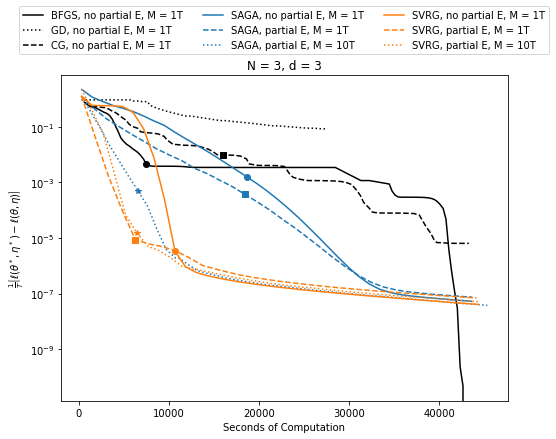

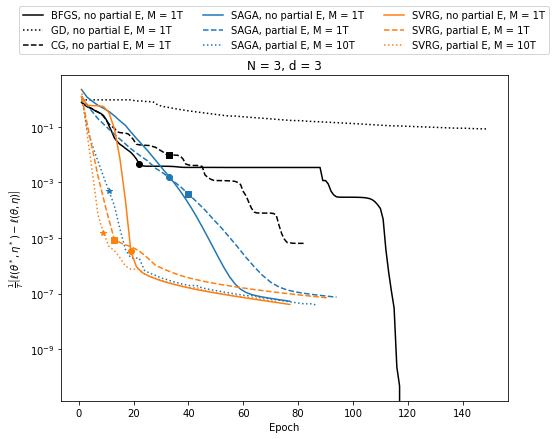

In [91]:
plot_ll(optims,x_time=True)#,xlims=[0,600],ylims=[1e-4,1e1])
plot_ll(optims,x_time=False)#,xlims=[0,100],ylims=[1e-4,1e1])

In [55]:
'''
for method in methods:#["EM","SGD","SAG","SVRG","SAGA"]:
    for partial_E in [0,0.5,1]:
        PE = (partial_E == 0.5) or (partial_E == 1)
        M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
        if (method,partial_E) in optims:
            plot_results(optims[(method,partial_E)],
                         ll_star,method,PE,M,optims[("control",0.0)].features)
'''

'\nfor method in methods:#["EM","SGD","SAG","SVRG","SAGA"]:\n    for partial_E in [0,0.5,1]:\n        PE = (partial_E == 0.5) or (partial_E == 1)\n        M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)\n        if (method,partial_E) in optims:\n            plot_results(optims[(method,partial_E)],\n                         ll_star,method,PE,M,optims[("control",0.0)].features)\n'